# Bitcoin & Supplementary Data Cleaning and Analysis
This notebook loads in all data sources, combines, cleans and extracts features for a Bitcoin Price Prediction task.

The tweets loaded here have already been processed in a separate notebook 'Tweet_process_final.ipynb'. Please consult that notebook for information on how the sentiment scores were obtained.

In [ ]:
#installing necessary packages
!pip install alpha_vantage

In [ ]:
#importing necessary packages
import kagglehub
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/My Drive/ML-project/tweet_daily_sentiment_final.csv' #previously processed tweets

Mounted at /content/drive


## Step 1: Bitcoin Data
This data was taken from an open source website 'Kaggle'. More information about the data can be found [here](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data). It has minute intervals of Bitcoin Close prices, recorded in UTC time (saved in Unix time).

In [ ]:
#Accessing dataset via Kaggle
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

#reading using pandas
df = pd.read_csv(path + "/btcusd_1-min_data.csv")
df.head()

100%|██████████| 90.1M/90.1M [00:00<00:00, 121MB/s]

Extracting files...


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


Some Quick initial Data Exploration

In [ ]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume
count,6.768280e+06,6.768281e+06,6.768281e+06,6.768281e+06,6.768281e+06,6.768281e+06
mean,1.528541e+09,1.494786e+04,1.495424e+04,1.494128e+04,1.494788e+04,5.445329e+00
std,1.173450e+08,2.047368e+04,2.048136e+04,2.046579e+04,2.047370e+04,2.289141e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.426947e+09,4.146800e+02,4.148100e+02,4.145000e+02,4.146600e+02,1.842000e-02
50%,1.528482e+09,6.307750e+03,6.309970e+03,6.305470e+03,6.307820e+03,4.981180e-01
75%,1.630017e+09,2.348153e+04,2.349097e+04,2.347200e+04,2.348159e+04,3.162937e+00
max,1.739578e+09,1.089460e+05,1.090300e+05,1.087760e+05,1.089600e+05,5.853852e+03


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6768281 entries, 0 to 6768280
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 309.8 MB


A period of two years (2022 -2024) was selected to be investigated for this project.

In [ ]:
#Time and filtering
#converting unix time
#can see date is currently a float and needs to be converted
df['Time_UTC'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)


#setting filter years
start_year = 2022
end_year = 2024

#filtering the dataset for desired subset
df = df[(df['Time_UTC'].dt.year >= start_year) & (df['Time_UTC'].dt.year <= end_year)]

#Coverting to Eastern Time to match alpha vantage data - creating separate column
df['Time_ET'] = df['Time_UTC'].dt.tz_convert('America/New_York')


<ipython-input-6-e41280ea33cd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_ET'] = df['Time_UTC'].dt.tz_convert('America/New_York')


In [ ]:
df

,Timestamp,Open,High,Low,Close,Volume,Time_UTC,Time_ET
5259119,1.640995e+09,46659.24,46674.91,46588.98,46588.98,4.516402,2022-01-01 00:00:00+00:00,2021-12-31 19:00:00-05:00
5259120,1.640995e+09,46588.98,46632.33,46588.98,46632.33,4.851013,2022-01-01 00:01:00+00:00,2021-12-31 19:01:00-05:00
5259121,1.640995e+09,46618.53,46636.33,46618.53,46636.33,0.178120,2022-01-01 00:02:00+00:00,2021-12-31 19:02:00-05:00
5259122,1.640995e+09,46620.43,46622.43,46605.09,46622.43,0.057885,2022-01-01 00:03:00+00:00,2021-12-31 19:03:00-05:00
5259123,1.640995e+09,46617.73,46631.03,46577.10,46577.10,0.296696,2022-01-01 00:04:00+00:00,2021-12-31 19:04:00-05:00
...,...,...,...,...,...,...,...,...
6737274,1.735689e+09,93476.00,93476.00,93471.00,93471.00,0.179799,2024-12-31 23:55:00+00:00,2024-12-31 18:55:00-05:00
6737275,1.735689e+09,93469.00,93469.00,93469.00,93469.00,0.021400,2024-12-31 23:56:00+00:00,2024-12-31 18:56:00-05:00
6737276,1.735689e+09,93462.00,93462.00,93413.00,93427.00,0.034750,2024-12-31 23:57:00+00:00,2024-12-31 18:57:00-05:00
6737277,1.735689e+09,93427.00,93427.00,93427.00,93427.00,0.000000,2024-12-31 23:58:00+00:00,2024-12-31 18:58:00-05:00


As the Alpha Vantage data used later is likely using Eastern Time to record the Close prices, the Close price was converted to ET and three verions of the close price were collected: Close Average, Close UTC Midnight and Close ET 4pm. IT can be further investigated if the choice of close time has an effect on the predictor variables.

In [ ]:
#accessing 4pm (ET) and 00:00 (UTC)

#Group by time
df_daily = df.groupby(df['Time_UTC'].dt.date) #each day

#function to get close values for certain times
#extracts the date and apllies filtering to the date group
def close_values(group):
  close_day = group['Time_UTC'].dt.date.iloc[0]
  close_ET =group[group['Time_ET'].dt.time == pd.to_datetime('16:00:00').time()]['Close']
  close_UTC = group[group['Time_UTC'].dt.time == pd.to_datetime('00:00:00').time()]['Close']
  close_avg = group['Close'].mean()

  return pd.Series({
      #'Close_Date': close_day,
      'Close_ET_4pm': close_ET.values[0] if not close_ET.empty else None,
      'Close_UTC_00': close_UTC.values[0] if not close_UTC.empty else None,
      'Close_Avg': close_avg
  })

In [ ]:
close_df = df_daily.apply(close_values).reset_index()
close_df

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg
0,2022-01-01,47318.36,46588.98,46873.902396
1,2022-01-02,47350.32,47617.47,47315.465979
2,2022-01-03,46652.02,47029.48,47009.836632
3,2022-01-04,46792.11,46465.49,46455.647465
4,2022-01-05,46633.06,45669.55,46300.825521
...,...,...,...,...
1091,2024-12-27,94515.00,NaN,95207.792793
1092,2024-12-28,NaN,94148.00,94148.000000
1093,2024-12-29,93635.00,NaN,94203.345345
1094,2024-12-30,NaN,93505.00,93505.000000


In [ ]:
close_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time_UTC      1096 non-null   object 
 1   Close_ET_4pm  1043 non-null   float64
 2   Close_UTC_00  1043 non-null   float64
 3   Close_Avg     1096 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.4+ KB


In [ ]:
#checking df for NaNs
close_df.isna().sum()

,0
Time_UTC,0
Close_ET_4pm,53
Close_UTC_00,53
Close_Avg,0


Checking for missing values highlighted issues with the last few weeks of data, which were then dropped.

In [ ]:
#checking missing times
close_df[close_df.isna().any(axis=1)]

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg
990,2024-09-17,NaN,58185.0,57978.925620
991,2024-09-18,59968.0,NaN,60075.591592
992,2024-09-19,NaN,61750.0,61750.000000
993,2024-09-20,62829.0,NaN,63145.717718
994,2024-09-21,NaN,63211.0,63211.000000
...,...,...,...,...
1091,2024-12-27,94515.0,NaN,95207.792793
1092,2024-12-28,NaN,94148.0,94148.000000
1093,2024-12-29,93635.0,NaN,94203.345345
1094,2024-12-30,NaN,93505.0,93505.000000


In [ ]:
#checking some of the dates with NaN in the original dataset
day_df = df[df['Time_UTC'].dt.date == pd.to_datetime('2024-12-28').date()] #investigating
day_df

,Timestamp,Open,High,Low,Close,Volume,Time_UTC,Time_ET
6735279,1.735344e+09,94159.0,94159.0,94118.0,94148.0,0.015052,2024-12-28 00:00:00+00:00,2024-12-27 19:00:00-05:00


In [ ]:
close_df

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg
0,2022-01-01,47318.36,46588.98,46873.902396
1,2022-01-02,47350.32,47617.47,47315.465979
2,2022-01-03,46652.02,47029.48,47009.836632
3,2022-01-04,46792.11,46465.49,46455.647465
4,2022-01-05,46633.06,45669.55,46300.825521
...,...,...,...,...
1091,2024-12-27,94515.00,NaN,95207.792793
1092,2024-12-28,NaN,94148.00,94148.000000
1093,2024-12-29,93635.00,NaN,94203.345345
1094,2024-12-30,NaN,93505.00,93505.000000


In [ ]:
# Find the rows where 'Date' is greater than or equal to '2024-09-17'
#make sure time is in datetime format
close_df['Time_UTC']= pd.to_datetime(close_df['Time_UTC'])

#filtering date the NaNs start
date_filter = close_df['Time_UTC'] >= '2024-09-17' #date NaNs start

# Drop those rows
close_df.drop(close_df[date_filter].index, inplace=True)


In [ ]:
close_df

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg
0,2022-01-01,47318.36,46588.98,46873.902396
1,2022-01-02,47350.32,47617.47,47315.465979
2,2022-01-03,46652.02,47029.48,47009.836632
3,2022-01-04,46792.11,46465.49,46455.647465
4,2022-01-05,46633.06,45669.55,46300.825521
...,...,...,...,...
985,2024-09-12,57538.00,57578.00,57919.718750
986,2024-09-13,59688.00,58329.00,58744.610417
987,2024-09-14,59838.00,60573.00,60043.732639
988,2024-09-15,59863.00,60013.00,60001.573611


In [ ]:
close_df.isna().sum()

,0
Time_UTC,0
Close_ET_4pm,0
Close_UTC_00,0
Close_Avg,0


In [ ]:
print(len(close_df))

990


Now that we have the final three close price columns wer can plot them all against time to look for trends and differences.

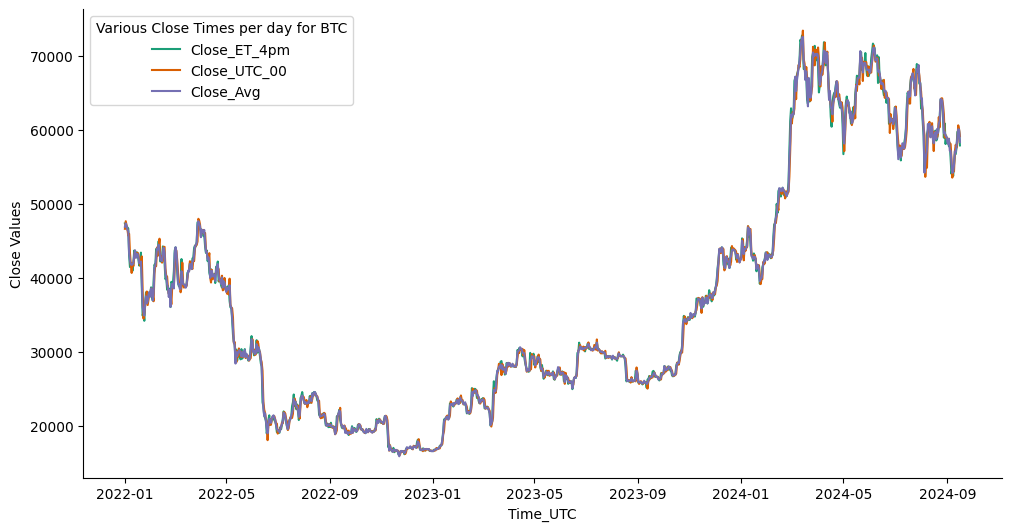

In [ ]:
#plotting close values
def _plot_series(series, series_name, x_col, y_col, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[x_col]
  ys = series[y_col]

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted = close_df.sort_values('Time_UTC', ascending=True)

_plot_series(df_sorted, 'Close_ET_4pm', 'Time_UTC', 'Close_ET_4pm', series_index=0)
_plot_series(df_sorted, 'Close_UTC_00', 'Time_UTC', 'Close_UTC_00', series_index=1)
_plot_series(df_sorted, 'Close_Avg', 'Time_UTC', 'Close_Avg', series_index=2)

sns.despine(fig=fig, ax=ax)
plt.xlabel('Time_UTC')
plt.ylabel('Close Values')

plt.legend(title = 'Various Close Times per day for BTC')
plt.show()

In [ ]:
close_df_2 = close_df.copy() #creating a copy as a backup

In [ ]:
print(len(close_df_2))

990


## Relative Strength Index
The RSI is often used in similar tasks due to its potential of highlighting the strengths and weaknesses of a stock and so it was included in this project. It was decided to perform this on the Close Price at UTC midnight, more information about why can be found in the report. Resources for implementing the RSI in python sourced [here](https://mayerkrebs.com/relative-strength-index-rsi-in-python/).


In [ ]:
#Creating the RSI
change = close_df["Close_UTC_00"].diff().fillna(0) #filling any nans with 0
change.dropna(inplace=True) # shouldn't be any

# Saving copies as backups
change_u = change.copy()
change_d = change.copy()

#initialinzing
change_u[change_u < 0] = 0
change_d[change_d > 0] = 0
change_d = abs(change_d) #keeping absolute values for change down

# Double checking sum of ups and downs equals original days
assert change.equals(change_u - change_d) #- as we took absolute value

# Calculate the rolling average for 14 days RSI
rolling_window = 14 #adjustable
avg_up = change_u.rolling(rolling_window, min_periods=1).mean()
avg_down = change_d.rolling(rolling_window, min_periods=1).mean()

#calculating
eps = 1e-10 # to avoid dividing by zero
rsi = 100 * avg_up / (avg_up + avg_down + eps)

#Adding to dataframe
close_df['RSI'] = rsi

#checking
close_df[["Close_UTC_00", "RSI"]].head(10)

,Close_UTC_00,RSI
0,46588.98,0.000000
1,47617.47,100.000000
2,47029.48,63.625285
3,46465.49,47.168271
4,45669.55,34.554715
5,45925.19,39.731130
6,43344.38,22.091191
7,41715.54,17.255869
8,40628.27,15.056097
9,41968.15,26.588812


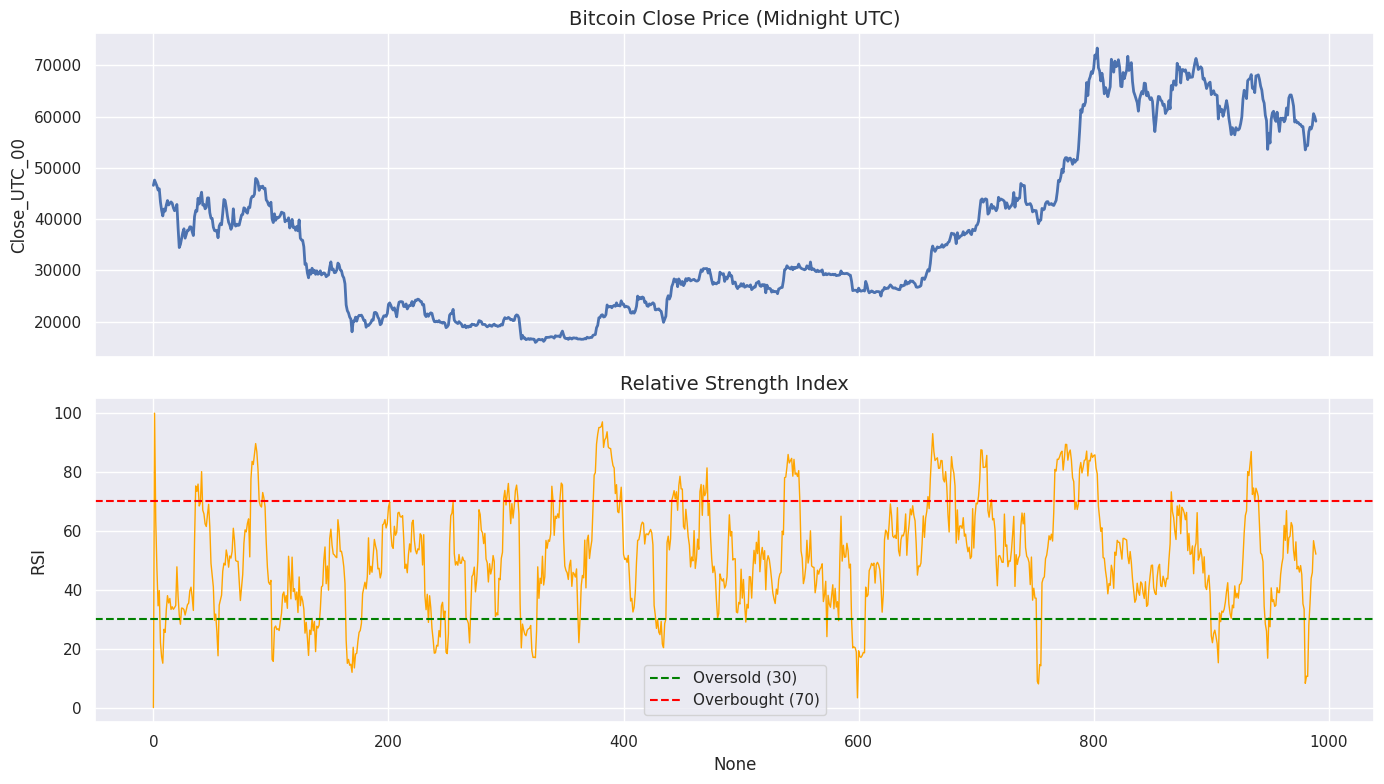

In [ ]:
#Plottig
sns.set_theme(style="darkgrid")

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# First chart: Bitcoin Closing Price
sns.lineplot(data=close_df, x=close_df.index, y="Close_UTC_00", ax=axes[0], linewidth=2)
axes[0].set_title("Bitcoin Close Price (Midnight UTC)", fontsize=14)

# Second chart: RSI
sns.lineplot(data=close_df, x=close_df.index, y="RSI", ax=axes[1], color="orange", linewidth=1)
axes[1].set_title("Relative Strength Index", fontsize=14)

# Add horizontal lines for Overbought (70) and Oversold (30)
axes[1].axhline(30, linestyle="--", linewidth=1.5, color="green", label="Oversold (30)")
axes[1].axhline(70, linestyle="--", linewidth=1.5, color="red", label="Overbought (70)")

# Add legend
axes[1].legend()

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


We can see this may well be a good indicator in this project

# Financial Data from Alpha Vantage
You will need a Alpha Vantage API Key for this part. Available for free [here](https://www.alphavantage.co/support/#api-key). Only the non premium functions are used here.

Various stocks were extracted using the Alpha Vantage API to be further explored here. Further information why is included in the report.

In [ ]:
#Alpha vantage API key
api_key = 'YOUR API KEY HERE' #Change this to your own API KEY

#defining tickers for stock
stock_symbol_1 = 'AAPL' #apple INC
stock_symbol_2 = 'NVDA' #nvidia CORP
stock_symbol_3 = 'ONEQ' #FIDELITY NASDAQ COMPOSITE INDEX ETF
stock_symbol_4 = 'SPY' #SPDR S&P 500 ETF Trust
stock_symbol_5 = 'TSLA' #tesla INC
stock_symbol_6 = 'COIN' #coinbase global inc - class A
stock_symbol_7 = 'PYPL' #paypal inc

# Initialize Alpha Vantage API client
ts = TimeSeries(key=api_key, output_format='pandas')

In [ ]:
#Retrieving stock market data for each stock/etf
stock_data_1, meta_data_1 = ts.get_daily(symbol=stock_symbol_1, outputsize='full')
stock_data_2, meta_data_2 = ts.get_daily(symbol=stock_symbol_2, outputsize='full')
stock_data_3, meta_data_3 = ts.get_daily(symbol=stock_symbol_3, outputsize='full')
stock_data_4, meta_data_4 = ts.get_daily(symbol=stock_symbol_4, outputsize='full')
stock_data_5, meta_data_4 = ts.get_daily(symbol=stock_symbol_5, outputsize='full')

In [ ]:
#rest of market data
stock_data_6, meta_data_6 = ts.get_daily(symbol=stock_symbol_6, outputsize='full')
stock_data_7, meta_data_7 = ts.get_daily(symbol=stock_symbol_7, outputsize='full')

## Creating chosen time period for each Stock/ETF
Creating just the chosen time period and extracting the close values

In [ ]:
#creating for each dataset
#apple
stock_data_1 = stock_data_1.sort_index()
stock_data_1_filtered = stock_data_1.loc['2022-01-01':'2024-09-16']
closing_price_aapl = stock_data_1_filtered['4. close']

#nvidia
stock_data_2 = stock_data_2.sort_index()
stock_data_2_filtered = stock_data_2.loc['2022-01-01':'2024-09-16']
closing_price_nvda = stock_data_2_filtered['4. close']

#FIDELITY NASDAQ COMPOSITE INDEX ETF
stock_data_3 = stock_data_3.sort_index()
stock_data_3_filtered = stock_data_3.loc['2022-01-01':'2024-09-16']
closing_price_oneq = stock_data_3_filtered['4. close']

#SPDR S&P 500 ETF Trust
stock_data_4 = stock_data_4.sort_index()
stock_data_4_filtered = stock_data_4.loc['2022-01-01':'2024-09-16']
closing_price_spy = stock_data_4_filtered['4. close']

#tesla INC
stock_data_5 = stock_data_5.sort_index()
stock_data_5_filtered = stock_data_5.loc['2022-01-01':'2024-09-16']
closing_price_tsla = stock_data_5_filtered['4. close']

#coinbase global inc - class A
stock_data_6 = stock_data_6.sort_index()
stock_data_6_filtered = stock_data_6.loc['2022-01-01':'2024-09-16']
closing_price_coin = stock_data_6_filtered['4. close']

#paypal inc
stock_data_7 = stock_data_7.sort_index()
stock_data_7_filtered = stock_data_7.loc['2022-01-01':'2024-09-16']
closing_price_pypl = stock_data_7_filtered['4. close']

In [ ]:
print(len(closing_price_aapl))
print(len(closing_price_nvda))
print(len(closing_price_oneq))
print(len(closing_price_spy))
print(len(closing_price_tsla))
print(len(closing_price_coin))
print(len(closing_price_pypl))

679
679
679
679
679
679
679


We can see each has 679 days, where we should have 990. Since they are all uniform, it is likely that trading days (i.e. weekends and holidays) are excluded. We will examine January to confirm this.

In [ ]:
closing_price_aapl.head(30)

,4. close
date,
2022-01-03,182.01
2022-01-04,179.70
2022-01-05,174.92
2022-01-06,172.00
2022-01-07,172.17
2022-01-10,172.19
2022-01-11,175.08
2022-01-12,175.53
2022-01-13,172.19


In [ ]:
#converting to dataframes and keeping just the close values
closing_price_aapl = pd.DataFrame(closing_price_aapl)
closing_price_aapl.rename(columns={'4. close': 'Close Value Apple'}, inplace=True)
closing_price_aapl

closing_price_nvda = pd.DataFrame(closing_price_nvda)
closing_price_nvda.rename(columns={'4. close': 'Close Value Nvidia'}, inplace=True)
closing_price_nvda

closing_price_oneq = pd.DataFrame(closing_price_oneq)
closing_price_oneq.rename(columns={'4. close': 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF'}, inplace=True)
closing_price_oneq

closing_price_spy = pd.DataFrame(closing_price_spy)
closing_price_spy.rename(columns={'4. close': 'Close Value SPDR S&P 500 ETF Trust'}, inplace=True)
closing_price_spy

closing_price_tsla = pd.DataFrame(closing_price_tsla)
closing_price_tsla.rename(columns={'4. close': 'Close Value Tesla'}, inplace=True)
closing_price_tsla

closing_price_coin = pd.DataFrame(closing_price_coin)
closing_price_coin.rename(columns={'4. close': 'Close Value Coinbase'}, inplace=True)
closing_price_coin

closing_price_pypl = pd.DataFrame(closing_price_pypl)
closing_price_pypl.rename(columns={'4. close': 'Close Value Paypal'}, inplace=True)
closing_price_pypl

,Close Value Paypal
date,
2022-01-03,194.94
2022-01-04,191.14
2022-01-05,187.16
2022-01-06,192.27
2022-01-07,187.60
...,...
2024-09-10,68.85
2024-09-11,69.35
2024-09-12,70.36


Mering all stocks into one dataset to make it easier to fill missing variables

In [ ]:
stock_df = pd.concat([closing_price_aapl, closing_price_nvda, closing_price_oneq, closing_price_spy, closing_price_tsla, closing_price_coin, closing_price_pypl], axis=1)
stock_df.reset_index()

stock_df

,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal
date,,,,,,,
2022-01-03,182.01,301.21,61.67,477.71,1199.78,251.05,194.94
2022-01-04,179.70,292.90,60.88,477.55,1149.59,250.15,191.14
2022-01-05,174.92,276.04,58.93,468.38,1088.12,234.23,187.16
2022-01-06,172.00,281.78,58.77,467.94,1064.70,234.00,192.27
2022-01-07,172.17,272.47,58.26,466.09,1026.96,232.33,187.60
...,...,...,...,...,...,...,...
2024-09-10,220.11,108.10,67.17,548.79,226.17,158.46,68.85
2024-09-11,222.66,116.91,68.63,554.42,228.13,157.15,69.35
2024-09-12,222.77,119.14,69.30,559.09,229.81,162.89,70.36


Since we can see it is non trading days missing, we will impute using forward fill to keep the placeholder stock price.

In [ ]:
#Checking dtype for time
close_df['Time_UTC'].dtype

dtype('<M8[ns]')

In [ ]:
# Using the bitcoin dataset to get the missing dates
allign_dates = pd.date_range(start=close_df['Time_UTC'].min(), end=close_df['Time_UTC'].max(), freq='D') #using bitcoin to include the 1st and 2nd of Jan

# Adding missing dates to the stock dataset
stock_df = stock_df.reindex(allign_dates)

#filling the missing dates
stock_df.ffill(inplace=True)

In [ ]:
# Using the bitcoin dataset to get the missing dates
allign_dates = pd.date_range(start=close_df['Time_UTC'].min(), end=close_df['Time_UTC'].max(), freq='D')

# Adding missing dates to the stock dataset
stock_df = stock_df.reindex(allign_dates)


#datetime
#stock_df.index = pd.to_datetime(stock_df.index)

In [ ]:
stock_df

,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,182.01,301.21,61.67,477.71,1199.78,251.05,194.94
2022-01-04,179.70,292.90,60.88,477.55,1149.59,250.15,191.14
2022-01-05,174.92,276.04,58.93,468.38,1088.12,234.23,187.16
...,...,...,...,...,...,...,...
2024-09-12,222.77,119.14,69.30,559.09,229.81,162.89,70.36
2024-09-13,222.50,119.10,69.78,562.01,230.29,163.05,70.10
2024-09-14,222.50,119.10,69.78,562.01,230.29,163.05,70.10
2024-09-15,222.50,119.10,69.78,562.01,230.29,163.05,70.10


We are still missing the first two dates as forward fill does not fill backwards. We will quickly access the last available close price for each stock before the 3rd and impute manually.

In [ ]:
#Finding the last close price for each stock before the 3rd of January
#apple
stock_data_1 = stock_data_1.sort_index()
stock_data_1_week = stock_data_1.loc['2021-12-31':'2022-01-03']
closing_price_aapl_week = stock_data_1_week['4. close']

#nvidia
stock_data_2 = stock_data_2.sort_index()
stock_data_2_week = stock_data_2.loc['2021-12-31':'2022-01-03']
closing_price_nvda_week = stock_data_2_week['4. close']

#FIDELITY NASDAQ COMPOSITE INDEX ETF
stock_data_3 = stock_data_3.sort_index()
stock_data_3_week = stock_data_3.loc['2021-12-31':'2022-01-03']
closing_price_oneq_week = stock_data_3_week['4. close']

#SPDR S&P 500 ETF Trust
stock_data_4 = stock_data_4.sort_index()
stock_data_4_week = stock_data_4.loc['2021-12-31':'2022-01-03']
closing_price_spy_week = stock_data_4_week['4. close']

#tesla INC
stock_data_5 = stock_data_5.sort_index()
stock_data_5_week = stock_data_5.loc['2021-12-31':'2022-01-03']
closing_price_tsla_week = stock_data_5_week['4. close']

#coinbase global inc - class A
stock_data_6 = stock_data_6.sort_index()
stock_data_6_week = stock_data_6.loc['2021-12-31':'2022-01-03']
closing_price_coin_week = stock_data_6_week['4. close']

#paypal inc
stock_data_7 = stock_data_7.sort_index()
stock_data_7_week = stock_data_7.loc['2021-12-31':'2022-01-03']
closing_price_pypl_week = stock_data_7_week['4. close']

In [ ]:
print(closing_price_aapl_week)
print(closing_price_nvda_week)
print(closing_price_oneq_week)
print(closing_price_spy_week)
print(closing_price_tsla_week)
print(closing_price_coin_week)
print(closing_price_pypl_week)


date
2021-12-31    177.57
2022-01-03    182.01
Name: 4. close, dtype: float64
date
2021-12-31    294.11
2022-01-03    301.21
Name: 4. close, dtype: float64
date
2021-12-31    60.90
2022-01-03    61.67
Name: 4. close, dtype: float64
date
2021-12-31    474.96
2022-01-03    477.71
Name: 4. close, dtype: float64
date
2021-12-31    1056.78
2022-01-03    1199.78
Name: 4. close, dtype: float64
date
2021-12-31    252.37
2022-01-03    251.05
Name: 4. close, dtype: float64
date
2021-12-31    188.58
2022-01-03    194.94
Name: 4. close, dtype: float64


In [ ]:
# Adding in the last available date for each stock, i.e. the 31st to the 1st and 2nd
#the first
stock_df.loc['2022-01-01'] = {
    'Close Value Apple': 177.57,
    'Close Value Nvidia': 294.11,
    'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF': 60.90,
    'Close Value SPDR S&P 500 ETF Trust': 474.96,
    'Close Value Tesla': 1056.78,
    'Close Value Coinbase': 252.37,
    'Close Value Paypal': 188.58
}
#the second
stock_df.loc['2022-01-02'] = {
    'Close Value Apple': 177.57,
    'Close Value Nvidia': 294.11,
    'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF': 60.90,
    'Close Value SPDR S&P 500 ETF Trust': 474.96,
    'Close Value Tesla': 1056.78,
    'Close Value Coinbase': 252.37,
    'Close Value Paypal': 188.58
}

#stock_df.reset_index(inplace=True)
#stock_df.rename(columns={'index': 'Date'}, inplace=True)

In [ ]:
stock_df.head()

,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal
2022-01-01,177.57,294.11,60.90,474.96,1056.78,252.37,188.58
2022-01-02,177.57,294.11,60.90,474.96,1056.78,252.37,188.58
2022-01-03,182.01,301.21,61.67,477.71,1199.78,251.05,194.94
2022-01-04,179.70,292.90,60.88,477.55,1149.59,250.15,191.14
2022-01-05,174.92,276.04,58.93,468.38,1088.12,234.23,187.16


In [ ]:
#checking no more NaNs
stock_df.isna().sum()

,0
Close Value Apple,0
Close Value Nvidia,0
Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,0
Close Value SPDR S&P 500 ETF Trust,0
Close Value Tesla,0
Close Value Coinbase,0
Close Value Paypal,0


Finally we can merge the BTC and Stocks

In [ ]:
dataset_1 = pd.merge(close_df, stock_df, left_on='Time_UTC', right_index=True, how='left')
dataset_1

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg,RSI,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal
0,2022-01-01,47318.36,46588.98,46873.902396,0.000000,177.57,294.11,60.90,474.96,1056.78,252.37,188.58
1,2022-01-02,47350.32,47617.47,47315.465979,100.000000,177.57,294.11,60.90,474.96,1056.78,252.37,188.58
2,2022-01-03,46652.02,47029.48,47009.836632,63.625285,182.01,301.21,61.67,477.71,1199.78,251.05,194.94
3,2022-01-04,46792.11,46465.49,46455.647465,47.168271,179.70,292.90,60.88,477.55,1149.59,250.15,191.14
4,2022-01-05,46633.06,45669.55,46300.825521,34.554715,174.92,276.04,58.93,468.38,1088.12,234.23,187.16
...,...,...,...,...,...,...,...,...,...,...,...,...
985,2024-09-12,57538.00,57578.00,57919.718750,43.915297,222.77,119.14,69.30,559.09,229.81,162.89,70.36
986,2024-09-13,59688.00,58329.00,58744.610417,45.878600,222.50,119.10,69.78,562.01,230.29,163.05,70.10
987,2024-09-14,59838.00,60573.00,60043.732639,56.683651,222.50,119.10,69.78,562.01,230.29,163.05,70.10
988,2024-09-15,59863.00,60013.00,60001.573611,54.166968,222.50,119.10,69.78,562.01,230.29,163.05,70.10


In [ ]:
dataset_1.isna().sum()

,0
Time_UTC,0
Close_ET_4pm,0
Close_UTC_00,0
Close_Avg,0
RSI,0
Close Value Apple,0
Close Value Nvidia,0
Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,0
Close Value SPDR S&P 500 ETF Trust,0
Close Value Tesla,0


We are also going to create a subset of the dataset to match the Tweet sentiment scores we are about to import below.

In [ ]:
# create subset  that matches the timeframe of the tweets
dataset_1['Time_UTC'] = pd.to_datetime(dataset_1['Time_UTC'])

start_date = pd.to_datetime('2022-01-11')
end_date = pd.to_datetime('2022-06-29')

dataset_2_btc_stocks = dataset_1[(dataset_1['Time_UTC'] >= start_date) & (dataset_1['Time_UTC'] <= end_date)]
dataset_2_btc_stocks

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg,RSI,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal
10,2022-01-11,41761.57,41562.14,41976.982285,25.538158,175.08,278.17,59.03,469.75,1064.40,237.23,191.52
11,2022-01-12,43648.06,42764.23,42987.859528,33.337254,175.53,279.99,59.22,471.02,1106.22,234.70,187.20
12,2022-01-13,43178.22,43630.60,43679.544292,38.016271,172.19,265.75,57.76,464.53,1031.56,228.23,181.01
13,2022-01-14,43147.12,42765.83,42661.393736,35.527241,173.07,269.42,58.04,464.72,1049.61,230.03,178.42
14,2022-01-15,43427.55,43084.89,43108.710208,37.047937,173.07,269.42,58.04,464.72,1049.61,230.03,178.42
...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-06-25,20944.92,21240.67,21250.369646,25.543489,141.66,171.26,45.39,390.08,737.12,62.71,77.68
176,2022-06-26,21310.00,21208.04,21387.202549,26.191247,141.66,171.26,45.39,390.08,737.12,62.71,77.68
177,2022-06-27,20714.88,21279.31,21109.752069,28.650121,141.66,168.69,45.08,388.59,734.76,55.96,75.94
178,2022-06-28,20588.46,20857.57,20782.725354,38.674569,137.44,159.82,43.79,380.65,697.99,51.18,71.82


# Importing Tweets

As mentioned, these tweets were already processed and analysed in another notebook.

In [ ]:
tweets_df = pd.read_csv(file_path)
tweets_df.rename(columns={'date': 'Time_UTC'}, inplace=True)
tweets_df['Time_UTC'] = pd.to_datetime(tweets_df['Time_UTC'])
tweets_df

,Time_UTC,avg_sentiment_score
0,2022-01-11,0.210110
1,2022-01-12,0.260047
2,2022-01-13,0.222628
3,2022-01-14,0.253282
4,2022-01-19,0.208571
...,...,...
72,2022-06-24,0.154576
73,2022-06-25,0.179629
74,2022-06-26,0.195231
75,2022-06-28,0.151321


We know from the other notebook that we are missing over half the dates needed. We will use a similar approach as above to fill in these dates.

In [ ]:
# Same approach as earlier except using dataset 2 to get the missing days for the twitter dataset
allign_dates_2 = pd.date_range(start=tweets_df['Time_UTC'].min(), end=tweets_df['Time_UTC'].max(), freq='D') #using start and end dates from tweets as we can extrapolate back with these sentiments

#set time index
tweets_df.set_index('Time_UTC', inplace=True)

# Adding missing dates to the twitter dataset
tweets_df = tweets_df.reindex(allign_dates_2)

In [ ]:
tweets_df

,avg_sentiment_score
2022-01-11,0.210110
2022-01-12,0.260047
2022-01-13,0.222628
2022-01-14,0.253282
2022-01-15,NaN
...,...
2022-06-25,0.179629
2022-06-26,0.195231
2022-06-27,NaN
2022-06-28,0.151321


In [ ]:
#using forward fill to add in sentiment score placholders for the missing dates
tweets_df.ffill(inplace=True)
tweets_df

,avg_sentiment_score
2022-01-11,0.210110
2022-01-12,0.260047
2022-01-13,0.222628
2022-01-14,0.253282
2022-01-15,0.253282
...,...
2022-06-25,0.179629
2022-06-26,0.195231
2022-06-27,0.195231
2022-06-28,0.151321


In [ ]:
tweets_df.isna().sum()

,0
avg_sentiment_score,0


Now we can merge the data subsets together for a second dataset.

In [ ]:
#creating dataset 2
dataset_2 = pd.merge(dataset_2_btc_stocks, tweets_df, left_on='Time_UTC', right_index=True, how='left')
dataset_2

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg,RSI,Close Value Apple,Close Value Nvidia,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,Close Value SPDR S&P 500 ETF Trust,Close Value Tesla,Close Value Coinbase,Close Value Paypal,avg_sentiment_score
10,2022-01-11,41761.57,41562.14,41976.982285,25.538158,175.08,278.17,59.03,469.75,1064.40,237.23,191.52,0.210110
11,2022-01-12,43648.06,42764.23,42987.859528,33.337254,175.53,279.99,59.22,471.02,1106.22,234.70,187.20,0.260047
12,2022-01-13,43178.22,43630.60,43679.544292,38.016271,172.19,265.75,57.76,464.53,1031.56,228.23,181.01,0.222628
13,2022-01-14,43147.12,42765.83,42661.393736,35.527241,173.07,269.42,58.04,464.72,1049.61,230.03,178.42,0.253282
14,2022-01-15,43427.55,43084.89,43108.710208,37.047937,173.07,269.42,58.04,464.72,1049.61,230.03,178.42,0.253282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-06-25,20944.92,21240.67,21250.369646,25.543489,141.66,171.26,45.39,390.08,737.12,62.71,77.68,0.179629
176,2022-06-26,21310.00,21208.04,21387.202549,26.191247,141.66,171.26,45.39,390.08,737.12,62.71,77.68,0.195231
177,2022-06-27,20714.88,21279.31,21109.752069,28.650121,141.66,168.69,45.08,388.59,734.76,55.96,75.94,0.195231
178,2022-06-28,20588.46,20857.57,20782.725354,38.674569,137.44,159.82,43.79,380.65,697.99,51.18,71.82,0.151321


## EDA

#### Visualization
Apply double smoothing to Bitcoin Average Close pricing to see if there are seasonal patterns in the data.

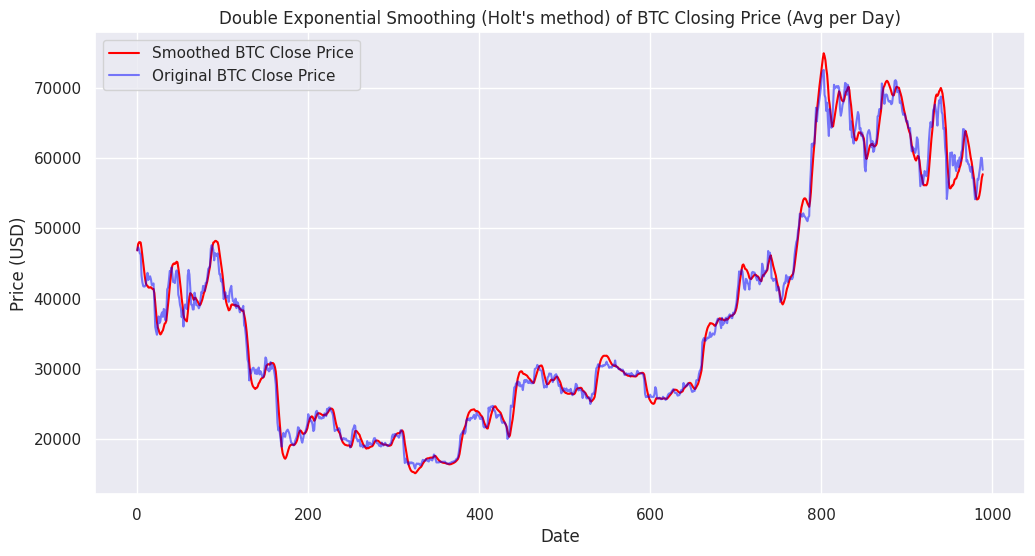

In [ ]:
# Apply double exponential smoothing (Holt's method) to the BTC closing price data
alpha = 0.2  # Level smoothing parameter (0 < alpha < 1)
beta = 0.2  # Trend smoothing parameter (0 < beta < 1)

# Initialize level and trend
level = dataset_1['Close_Avg'][0]
trend = dataset_1['Close_Avg'][1] - dataset_1['Close_Avg'][0]
smoothed_closing_price = [level]

# Apply Holt's method (Double Exponential Smoothing)
for i in range(1, len(dataset_1)):
    new_level = alpha * dataset_1['Close_Avg'][i] + (1 - alpha) * (level + trend)
    new_trend = beta * (new_level - level) + (1 - beta) * trend
    level, trend = new_level, new_trend
    smoothed_closing_price.append(new_level + new_trend)

# Plot the original and smoothed closing price
plt.figure(figsize=(12, 6))
plt.plot(dataset_1.index, smoothed_closing_price, label="Smoothed BTC Close Price", color="red")
plt.plot(dataset_1.index, dataset_1['Close_Avg'], label="Original BTC Close Price", color="blue", alpha=0.5)
plt.title("Double Exponential Smoothing (Holt's method) of BTC Closing Price (Avg per Day)")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(dataset_2.index) #doesnt start at 0, could reset of just use indexes below

Index([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
       ...
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179],
      dtype='int64', length=170)


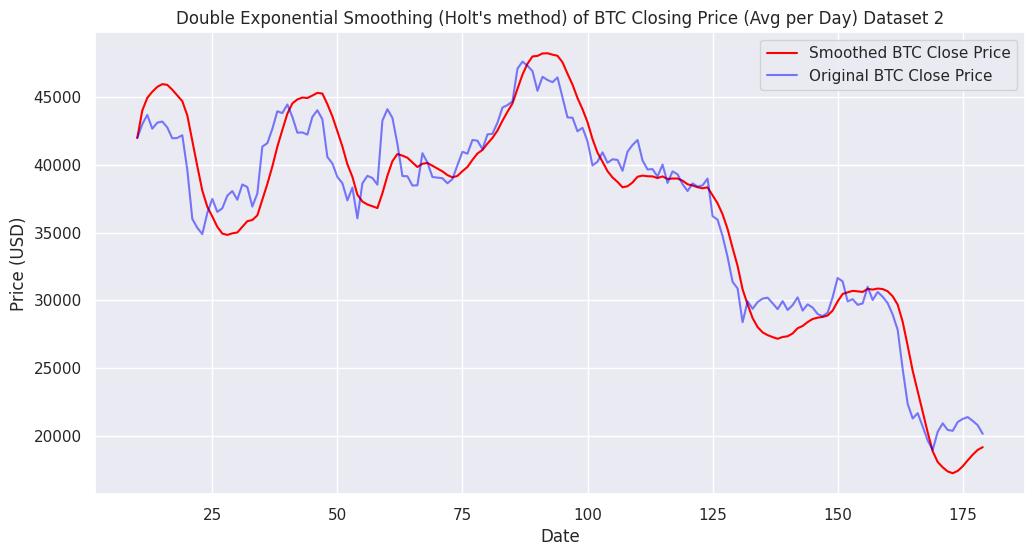

In [ ]:
# Apply double exponential smoothing (Holt's method) to the BTC closing price data
alpha = 0.2  # Level smoothing parameter (0 < alpha < 1)
beta = 0.2  # Trend smoothing parameter (0 < beta < 1)

# Initialize level and trend
level = dataset_2['Close_Avg'][10]
trend = dataset_2['Close_Avg'][11] - dataset_2['Close_Avg'][10]
smoothed_closing_price = [level]

# Apply Holt's method (Double Exponential Smoothing)
for i in dataset_2.index[1:]:
    new_level = alpha * dataset_2['Close_Avg'][i] + (1 - alpha) * (level + trend)
    new_trend = beta * (new_level - level) + (1 - beta) * trend
    level, trend = new_level, new_trend
    smoothed_closing_price.append(new_level + new_trend)

# Plot the original and smoothed closing price
plt.figure(figsize=(12, 6))
plt.plot(dataset_2.index, smoothed_closing_price, label="Smoothed BTC Close Price", color="red")
plt.plot(dataset_2.index, dataset_2['Close_Avg'], label="Original BTC Close Price", color="blue", alpha=0.5)
plt.title("Double Exponential Smoothing (Holt's method) of BTC Closing Price (Avg per Day) Dataset 2")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


It looks like there might be a pattern in the data as it seems to uniformally dip.

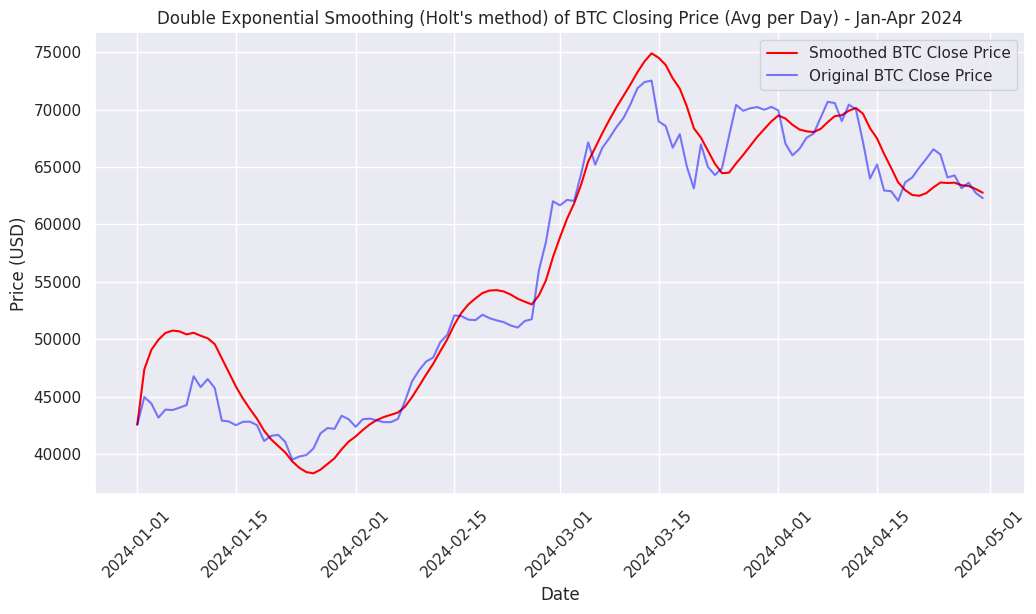

In [ ]:
# Four month period
start_date = '2024-01-01'
end_date = '2024-04-30'

# creating new four month subset
subset_data = dataset_1[(dataset_1['Time_UTC'] >= start_date) & (dataset_1['Time_UTC'] <= end_date)]

# Apply double exponential smoothing (Holt's method)
alpha = 0.2  # Level smoothing parameter (0 < alpha < 1)
beta = 0.2  # Trend smoothing parameter (0 < beta < 1)

# Initialize level and trend
level = subset_data['Close_Avg'].iloc[0]
trend = subset_data['Close_Avg'].iloc[1] - subset_data['Close_Avg'].iloc[0]
smoothed_closing_price = [level]

# Apply Holt's method (Double Exponential Smoothing)
for i in range(1, len(subset_data)):
    new_level = alpha * subset_data['Close_Avg'].iloc[i] + (1 - alpha) * (level + trend)
    new_trend = beta * (new_level - level) + (1 - beta) * trend
    level, trend = new_level, new_trend
    smoothed_closing_price.append(new_level + new_trend)

# Plot the original and smoothed closing price for the two months
plt.figure(figsize=(12, 6))
plt.plot(subset_data['Time_UTC'], smoothed_closing_price, label="Smoothed BTC Close Price", color="red")
plt.plot(subset_data['Time_UTC'], subset_data['Close_Avg'], label="Original BTC Close Price", color="blue", alpha=0.5)
plt.title("Double Exponential Smoothing (Holt's method) of BTC Closing Price (Avg per Day) - Jan-Apr 2024")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # better readability
plt.show()


# Univariate Outlier Detection

Using Boxplots to detect outliers in Data.


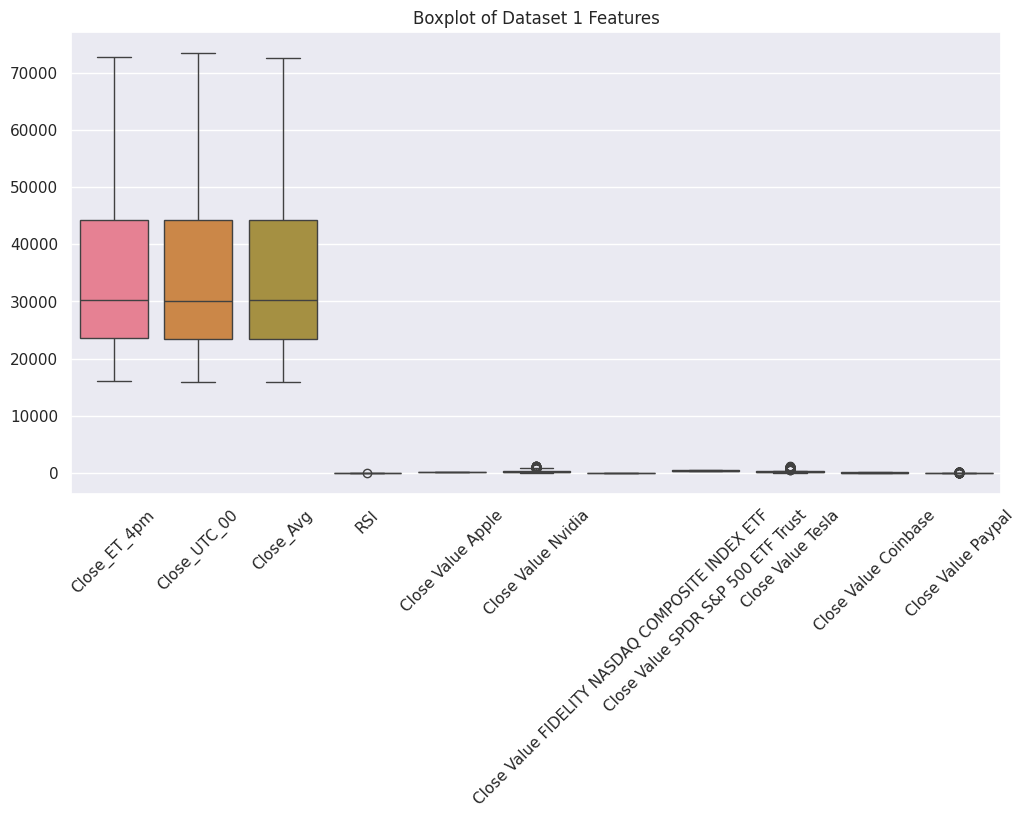

In [ ]:
# Visualize the distribution of each feature using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_1)
plt.title('Boxplot of Dataset 1 Features')
plt.xticks(rotation=45)
plt.show()

# Looking closer at Close Price for BTC
We will look for possible outliers in the Bitcoin prices.


In [ ]:
# Outlier detection using 3 standard deviations for Average Close Price
std_threshold = 3
mean_sw = dataset_1['Close_Avg'].mean()
std_sw = dataset_1['Close_Avg'].std()
upper_fence_std = mean_sw + std_threshold * std_sw
lower_fence_std = mean_sw - std_threshold * std_sw
outliers_std = dataset_1[(dataset_1['Close_Avg'] > upper_fence_std) | (dataset_1['Close_Avg'] < lower_fence_std)]

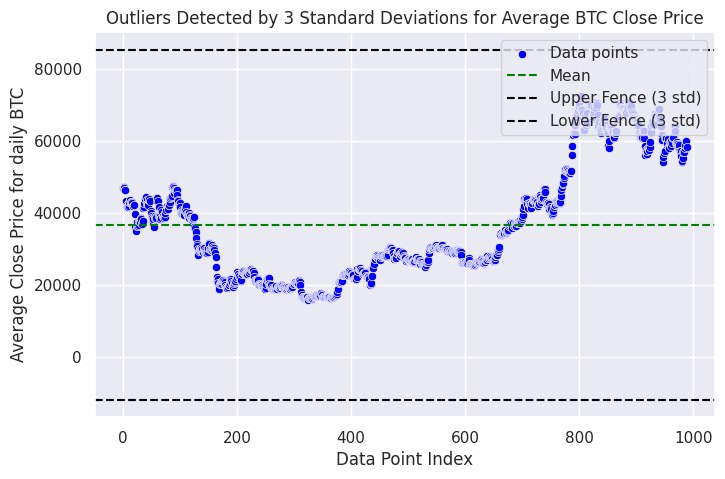

In [ ]:
# Visualize outliers detected by 3 standard deviations for 'Avg_Close'
plt.figure(figsize=(8, 5))
sns.scatterplot(x=dataset_1.index, y='Close_Avg', data=dataset_1, color='blue', label='Data points')
sns.scatterplot(x=outliers_std.index, y='Close_Avg', data=outliers_std, color='red', label='Outliers (3std)')
plt.axhline(y=mean_sw, color='green', linestyle='--', label='Mean')
plt.axhline(y=upper_fence_std, color='black', linestyle='--', label='Upper Fence (3 std)')
plt.axhline(y=lower_fence_std, color='black', linestyle='--', label='Lower Fence (3 std)')
plt.title('Outliers Detected by 3 Standard Deviations for Average BTC Close Price')
plt.xlabel('Data Point Index')
plt.ylabel('Average Close Price for daily BTC')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Outlier detection using 3 standard deviations for Average Close Price
std_threshold = 3
mean_sw = dataset_1['Close_UTC_00'].mean()
std_sw = dataset_1['Close_UTC_00'].std()
upper_fence_std = mean_sw + std_threshold * std_sw
lower_fence_std = mean_sw - std_threshold * std_sw
outliers_std = dataset_1[(dataset_1['Close_UTC_00'] > upper_fence_std) | (dataset_1['Close_UTC_00'] < lower_fence_std)]

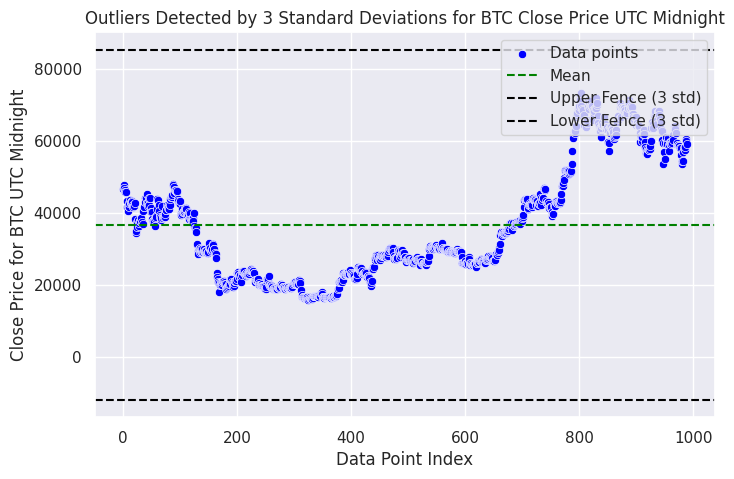

In [ ]:
# Visualize outliers detected by 3 standard deviations for 'Avg_Close'
plt.figure(figsize=(8, 5))
sns.scatterplot(x=dataset_1.index, y='Close_UTC_00', data=dataset_1, color='blue', label='Data points')
sns.scatterplot(x=outliers_std.index, y='Close_UTC_00', data=outliers_std, color='red', label='Outliers (3std)')
plt.axhline(y=mean_sw, color='green', linestyle='--', label='Mean')
plt.axhline(y=upper_fence_std, color='black', linestyle='--', label='Upper Fence (3 std)')
plt.axhline(y=lower_fence_std, color='black', linestyle='--', label='Lower Fence (3 std)')
plt.title('Outliers Detected by 3 Standard Deviations for BTC Close Price UTC Midnight')
plt.xlabel('Data Point Index')
plt.ylabel('Close Price for BTC UTC Midnight')
plt.legend(loc='upper right')
plt.show()

We can see from here the data has started to move away from the mean, however this more likely reflects a trend data is still within 3 standard deviations

# Relationships between features
Exploring the relationships present using correlation matrix and VIF.
We will start off by putting everything into a correlation matrix and whittling down.

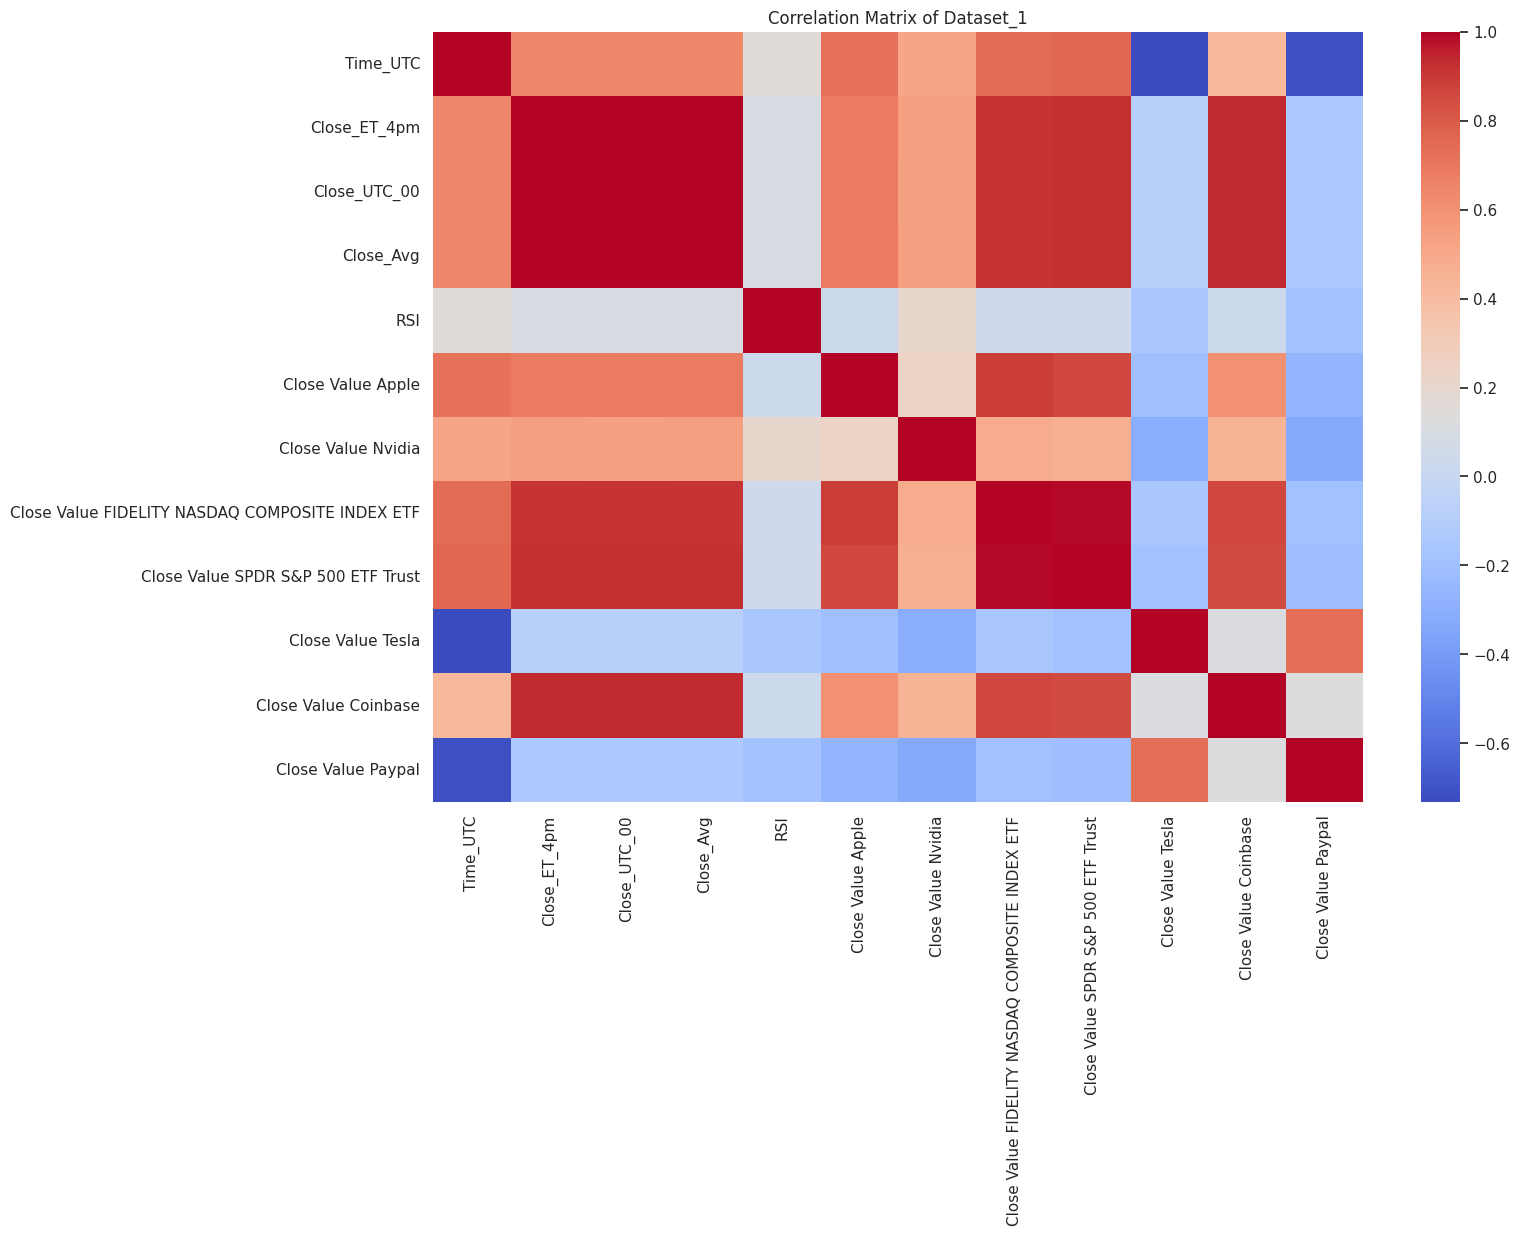

In [ ]:
# Visualize correlations between features
plt.figure(figsize=(15, 10))
sns.heatmap(dataset_1.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Dataset_1')
plt.show()

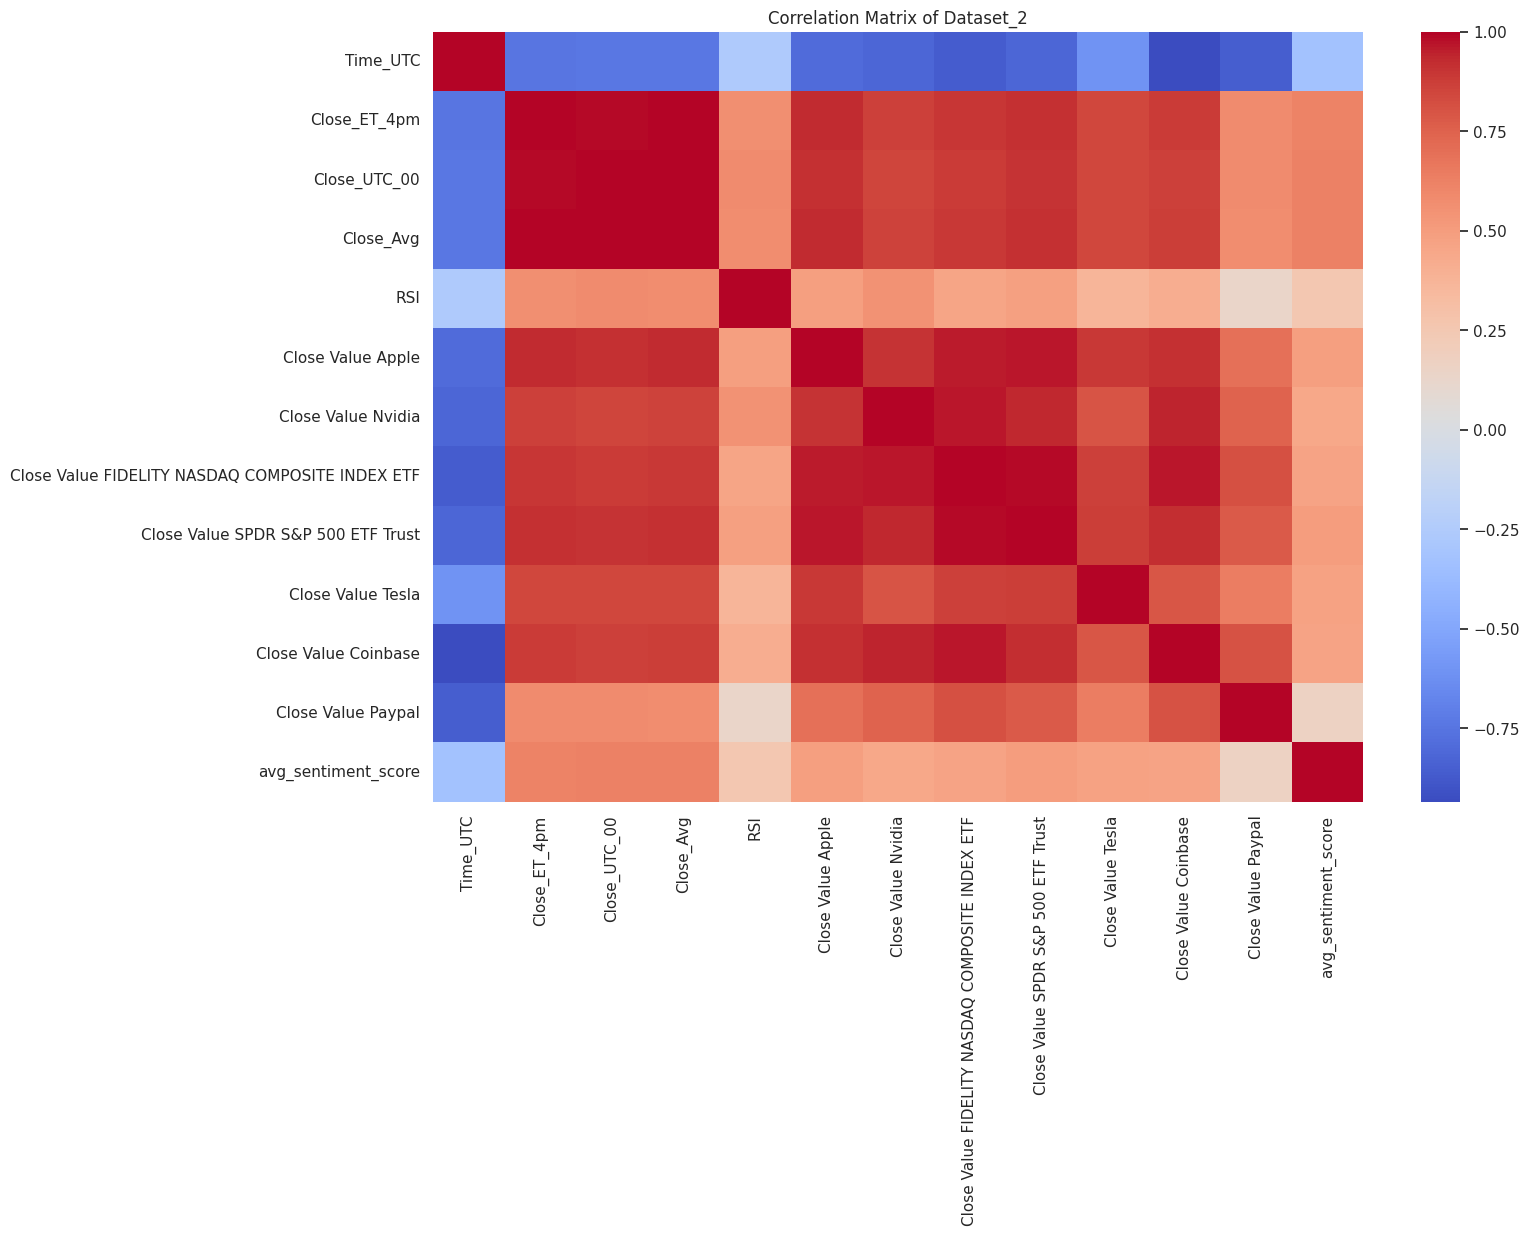

In [ ]:
# Visualize correlations between features
plt.figure(figsize=(15, 10))
sns.heatmap(dataset_2.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Dataset_2')
plt.show()

We can now extract features that look like they may have a high correlation with either the target and or eachother.
We can see that the RSI has more correlation in dataset 2 which covers a longer timeframe, which makes sense and indicates it may be useful for long term predictions.

In [ ]:
feature_subset = dataset_2[['Close_Avg', 'avg_sentiment_score', 'Close Value Coinbase', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF' ,	'Close Value SPDR S&P 500 ETF Trust', 'RSI', 'Close Value Apple']]


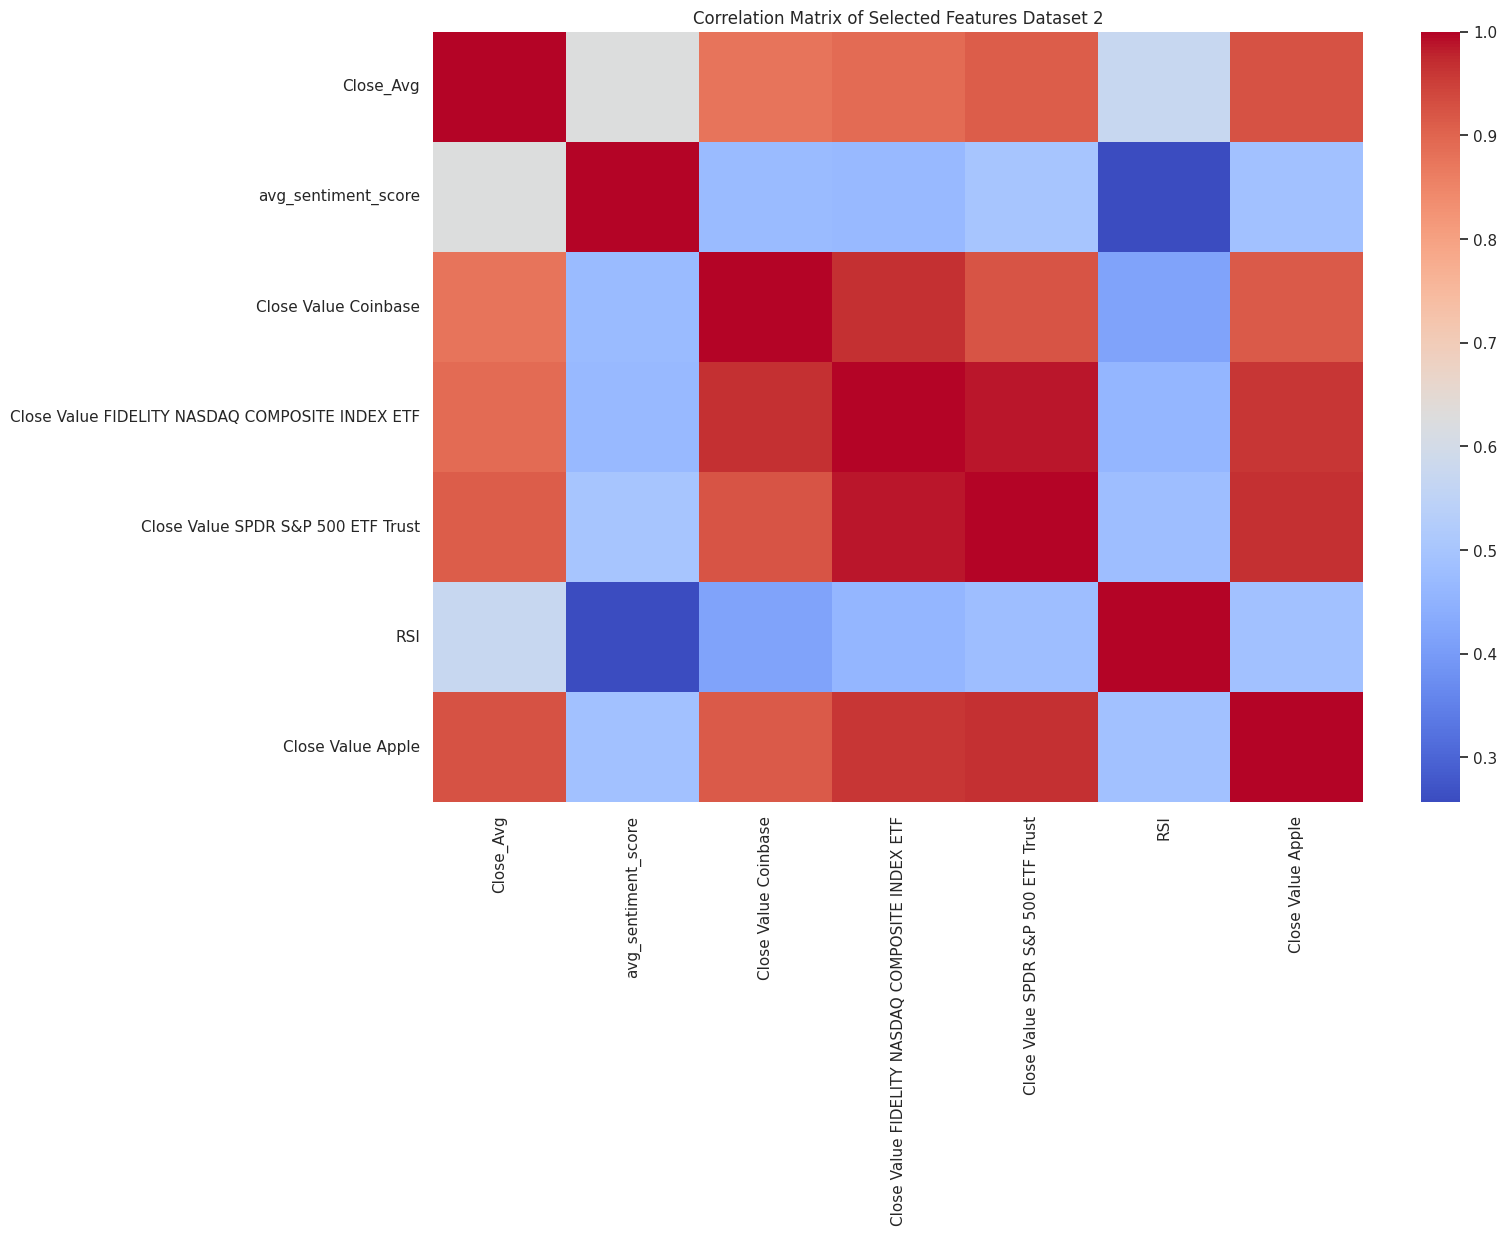

In [ ]:
# Visualize correlations between features
plt.figure(figsize=(15, 10))
sns.heatmap(feature_subset.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features Dataset 2')
plt.show()

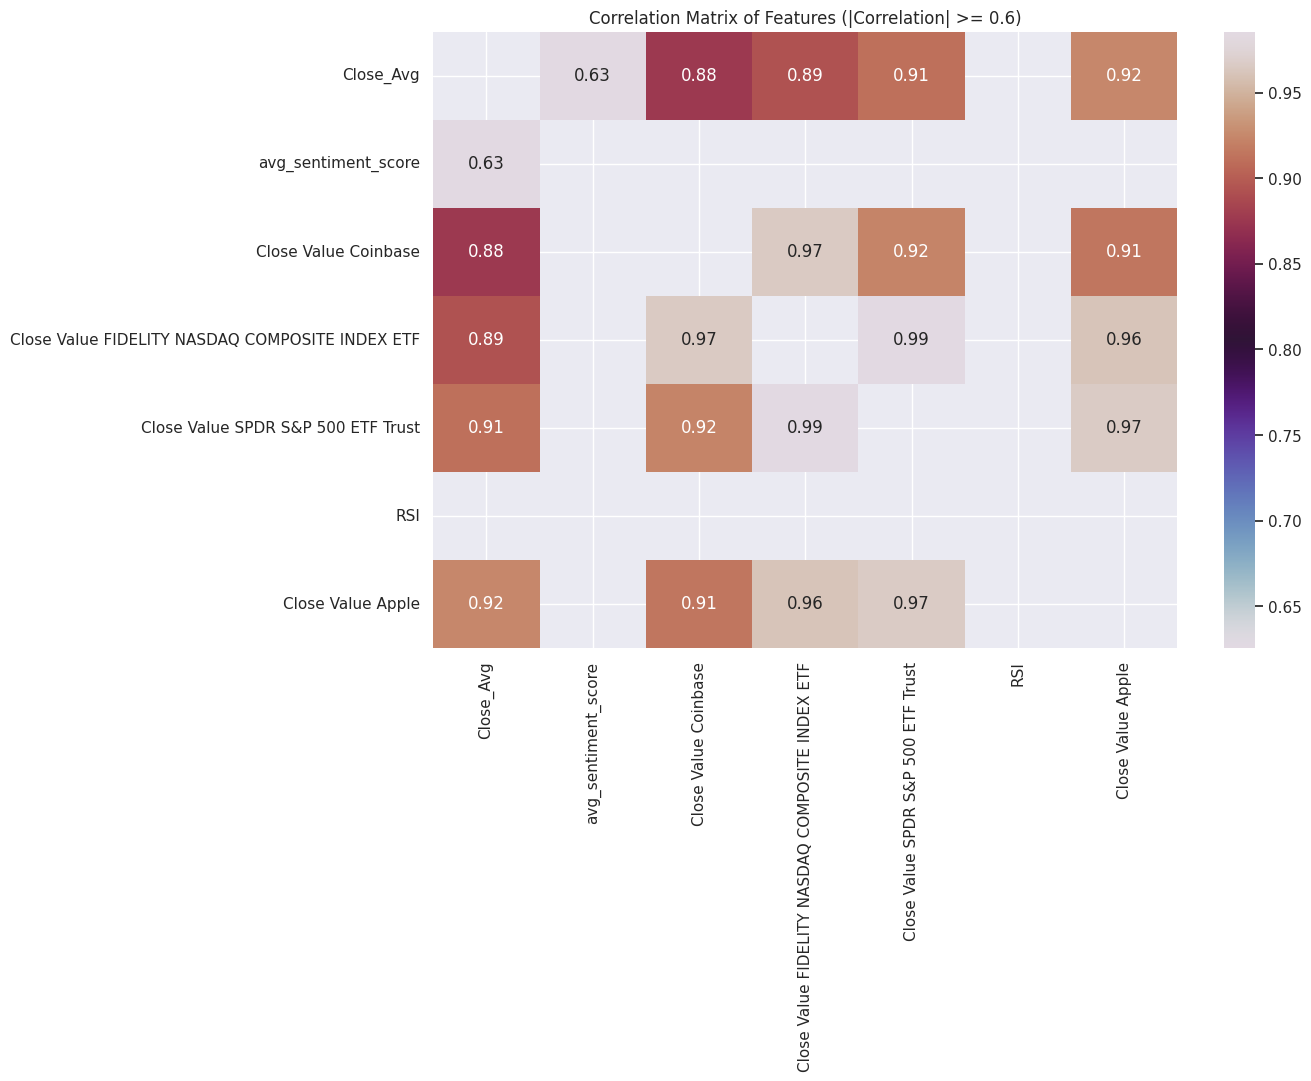

In [ ]:
# Visualize correlations between features with absolute correlation greater than or equal to 0.6
plt.figure(figsize=(12, 8))
corr_matrix = feature_subset.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',fmt=".2f")
plt.title('Correlation Matrix of Features (|Correlation| >= 0.6)')
plt.show()

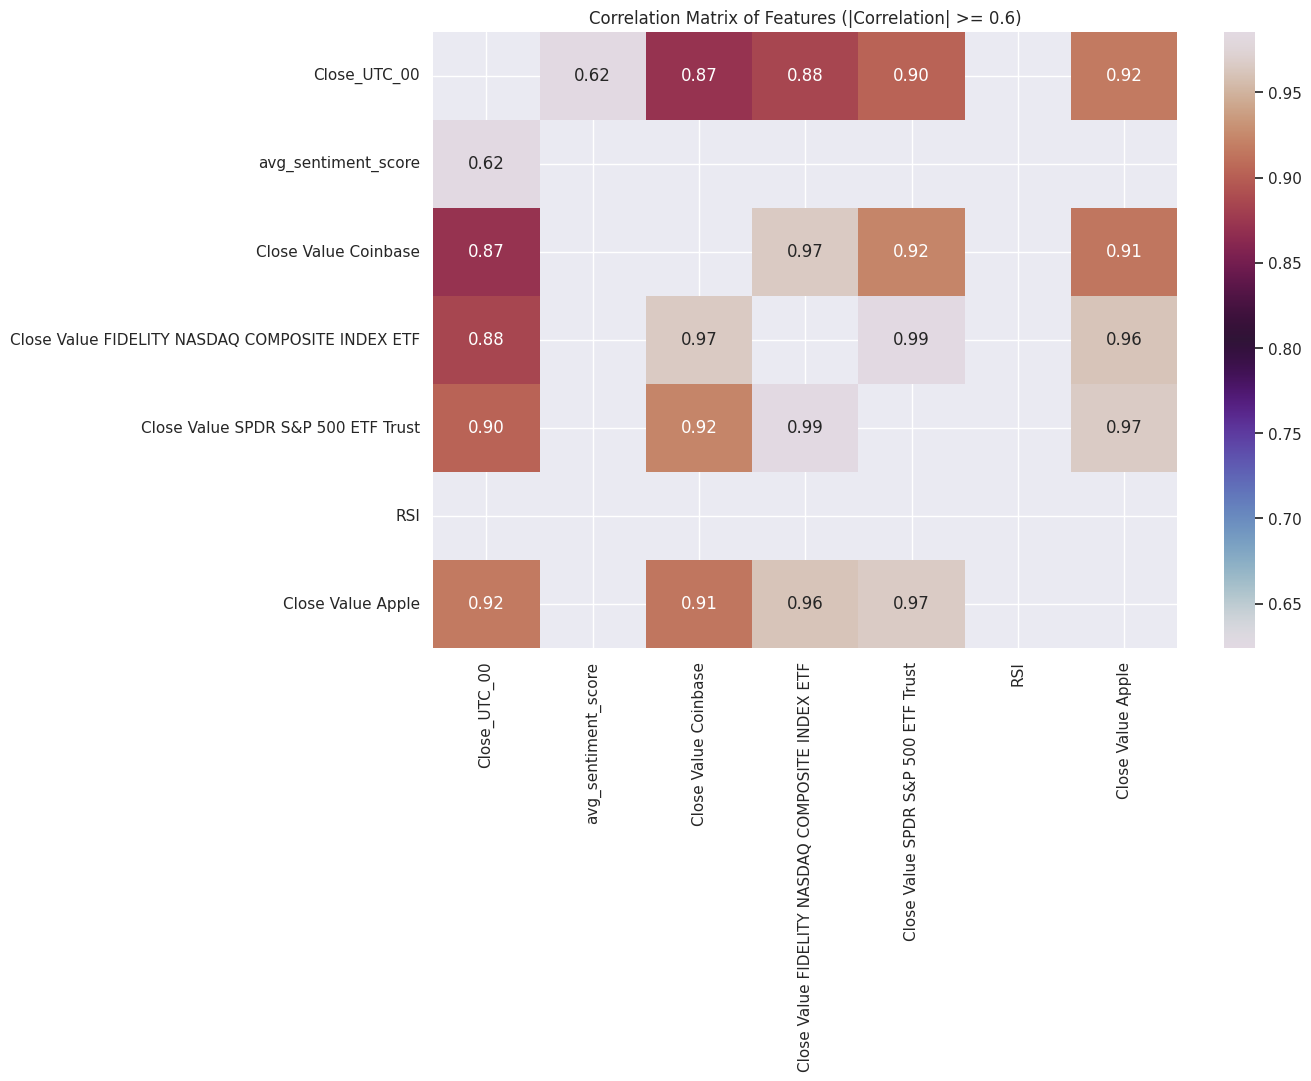

In [ ]:
# Visualize correlations between features with absolute correlation greater than or equal to 0.6
feature_subset_utc = dataset_2[['Close_UTC_00', 'avg_sentiment_score', 'Close Value Coinbase', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF' ,	'Close Value SPDR S&P 500 ETF Trust', 'RSI', 'Close Value Apple']]

plt.figure(figsize=(12, 8))
corr_matrix = feature_subset_utc.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',fmt=".2f")
plt.title('Correlation Matrix of Features (|Correlation| >= 0.6)')
plt.show()

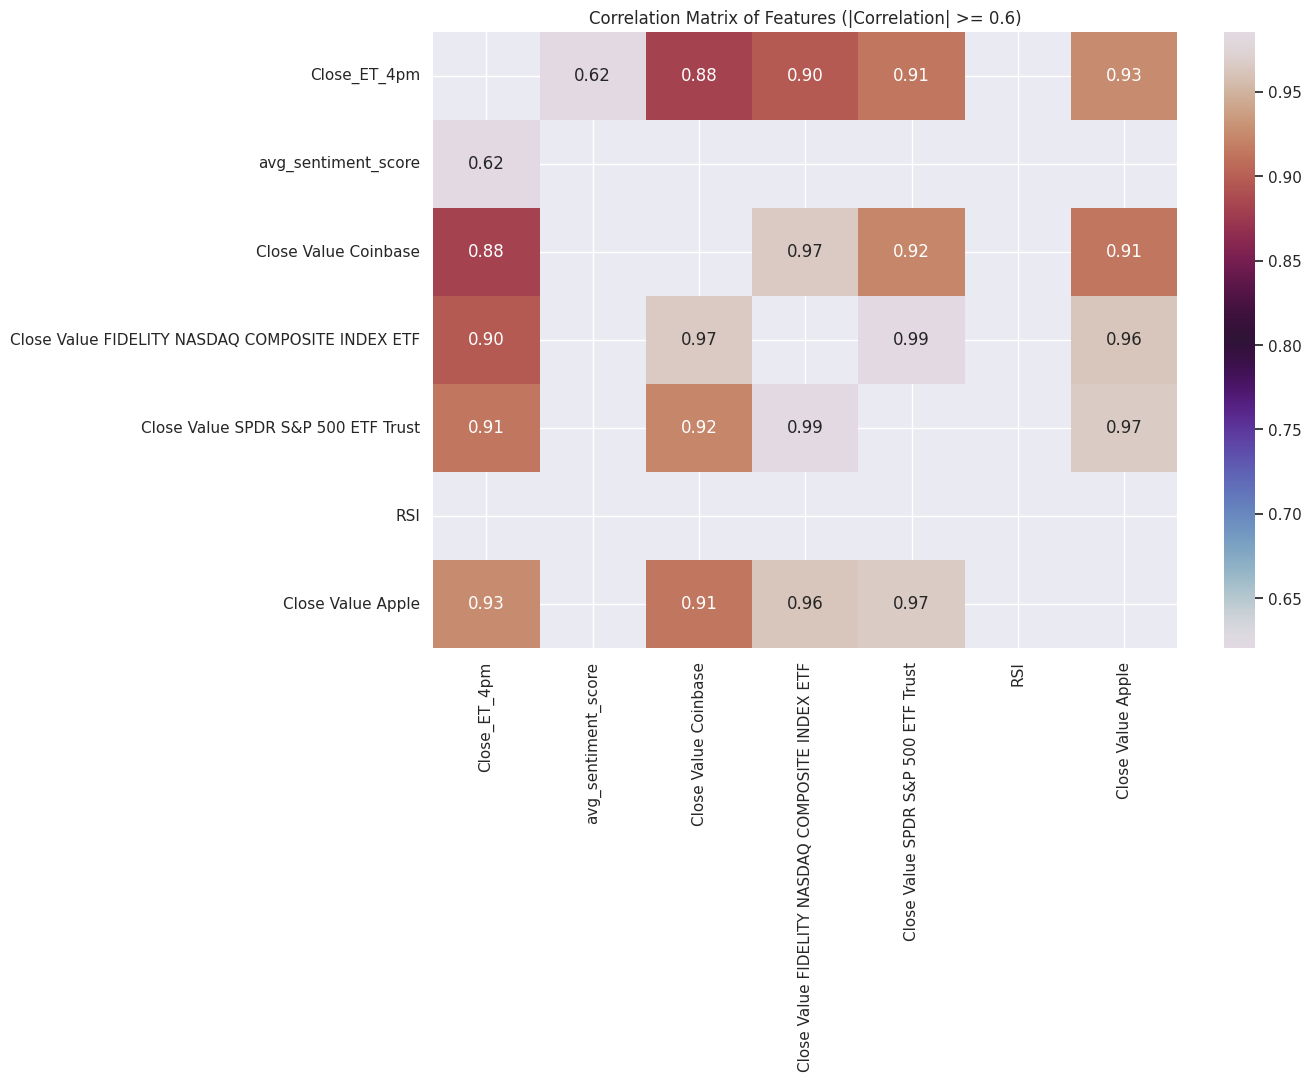

In [ ]:
# Visualize correlations between features with absolute correlation greater than or equal to 0.6
feature_subset_et = dataset_2[['Close_ET_4pm', 'avg_sentiment_score', 'Close Value Coinbase', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF' ,	'Close Value SPDR S&P 500 ETF Trust', 'RSI', 'Close Value Apple']]

plt.figure(figsize=(12, 8))
corr_matrix = feature_subset_et.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',fmt=".2f")
plt.title('Correlation Matrix of Features (|Correlation| >= 0.6)')
plt.show()

In [ ]:
feature_subset_2 = dataset_1[['Close_Avg', 'Close Value Apple', 'Close Value Coinbase', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF' ,	'Close Value SPDR S&P 500 ETF Trust', 'Close Value Nvidia', 'Close Value Tesla', 'RSI']]


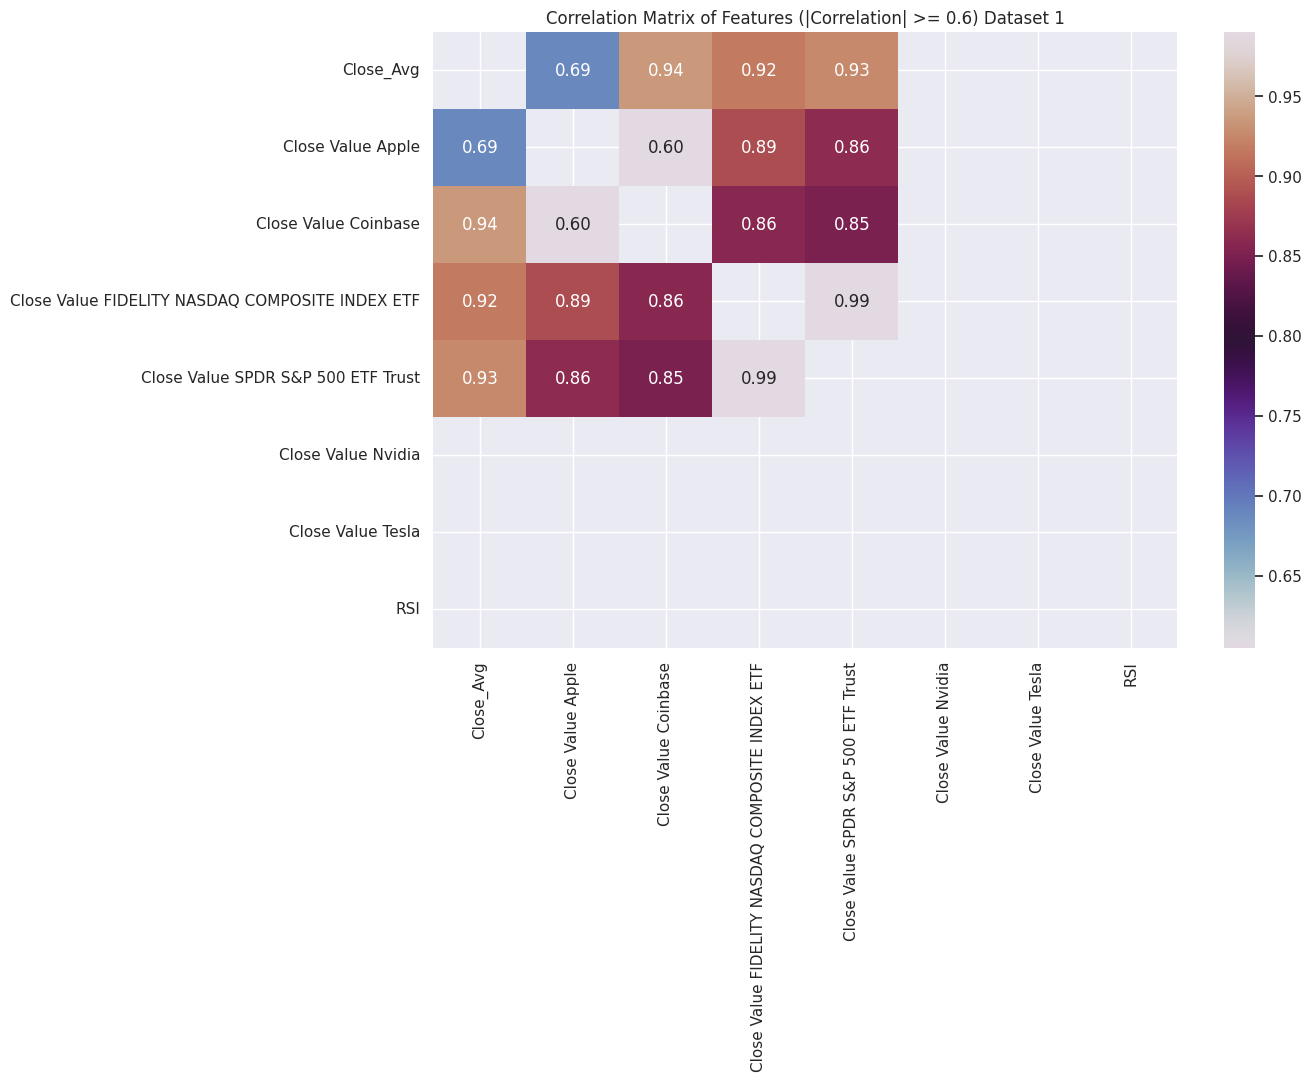

In [ ]:
# Visualize correlations between features with absolute correlation greater than or equal to 0.6

plt.figure(figsize=(12, 8))
corr_matrix = feature_subset_2.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',fmt=".2f")
plt.title('Correlation Matrix of Features (|Correlation| >= 0.6) Dataset 1')
plt.show()

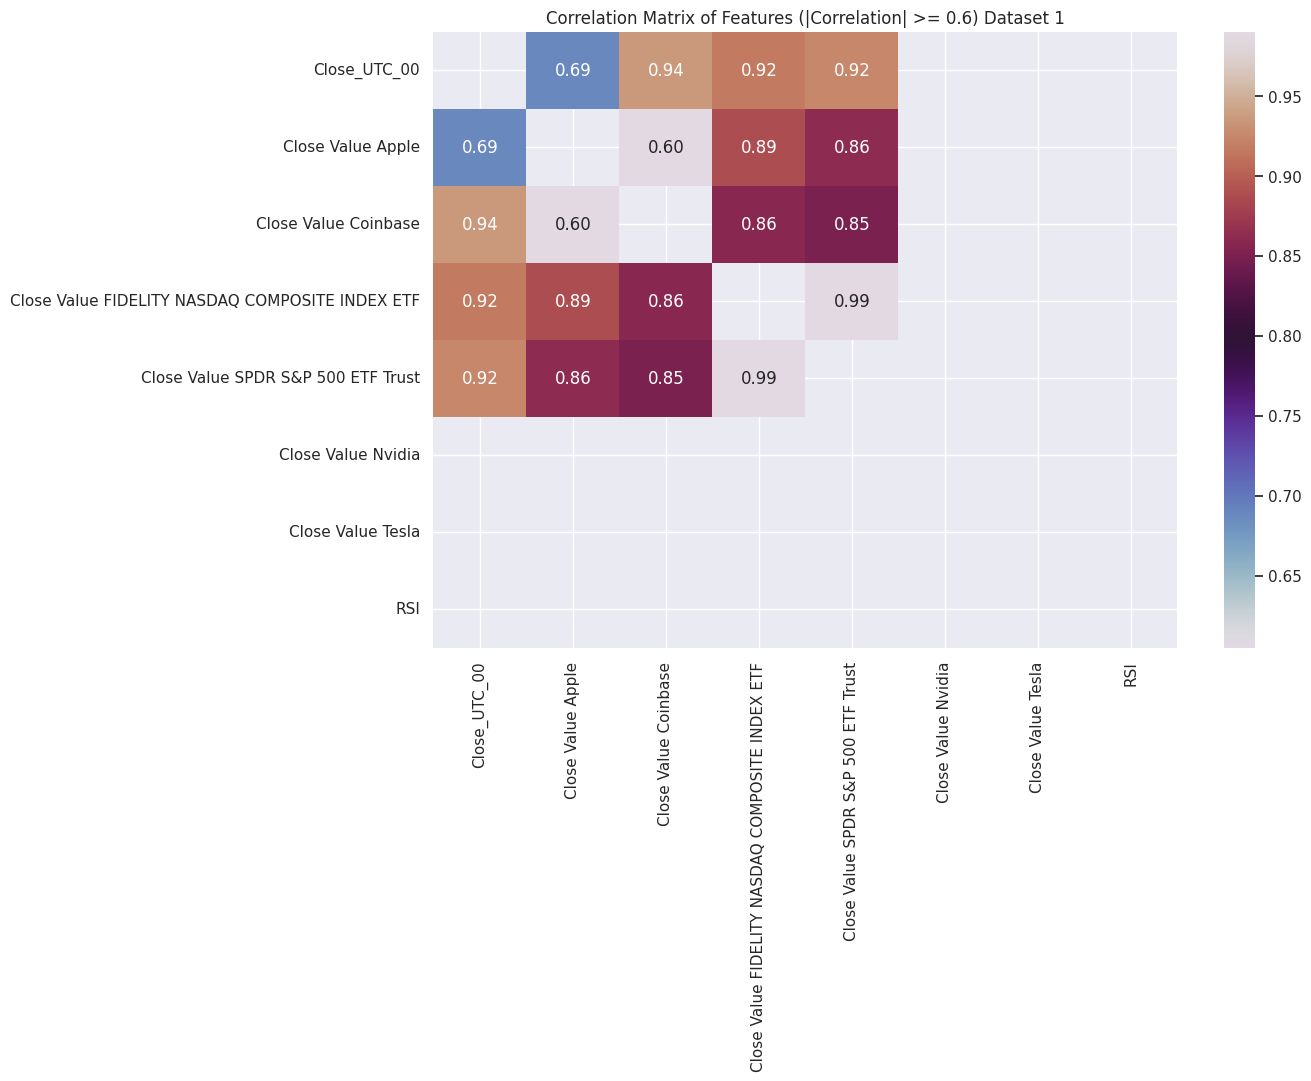

In [ ]:
feature_subset_2_utc = dataset_1[['Close_UTC_00', 'Close Value Apple', 'Close Value Coinbase', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF' ,	'Close Value SPDR S&P 500 ETF Trust', 'Close Value Nvidia', 'Close Value Tesla', 'RSI']]
# Visualize correlations between features with absolute correlation greater than or equal to 0.6

plt.figure(figsize=(12, 8))
corr_matrix = feature_subset_2_utc.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',fmt=".2f")
plt.title('Correlation Matrix of Features (|Correlation| >= 0.6) Dataset 1')
plt.show()


# Using Variance Inflation Factor
Using Statsmodel VIF to detect for the presence for Multicollinearity with potential predictors in the dataset.
We will apply this approach for Dataset 1 and 2

In [ ]:
features_d1 = dataset_1[['Close Value Apple', 'Close Value Nvidia', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Tesla', 'Close Value Coinbase', 'Close Value Paypal', 'RSI']]

features_d2 = dataset_2[[ 'avg_sentiment_score', 'Close Value Apple', 'Close Value Nvidia', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Tesla', 'Close Value Coinbase', 'Close Value Paypal', 'RSI']]

X1 = add_constant(features_d1)
X2 = add_constant(features_d2)


vif_data_1 = pd.DataFrame()
vif_data_1["Feature"] = X1.columns
vif_data_1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_data_1



,Feature,VIF
0,const,701.746223
1,Close Value Apple,15.657134
2,Close Value Nvidia,2.548132
3,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,164.217071
4,Close Value SPDR S&P 500 ETF Trust,83.238247
5,Close Value Tesla,2.652316
6,Close Value Coinbase,12.286681
7,Close Value Paypal,2.964602
8,RSI,1.095697


In [ ]:

vif_data_2 = pd.DataFrame()
vif_data_2["Feature"] = X2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_data_2

,Feature,VIF
0,const,2420.488572
1,avg_sentiment_score,2.071277
2,Close Value Apple,32.137454
3,Close Value Nvidia,32.321531
4,Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF,332.180528
5,Close Value SPDR S&P 500 ETF Trust,100.998625
6,Close Value Tesla,5.869374
7,Close Value Coinbase,34.485546
8,Close Value Paypal,8.432448
9,RSI,2.187342


In [ ]:
features_d3 = dataset_2[[ 'avg_sentiment_score', 'Close Value Apple', 'Close Value Nvidia', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Tesla', 'Close Value Coinbase', 'Close Value Paypal']]

In [ ]:
X3 = add_constant(features_d3)
vif_data_3 = pd.DataFrame()
vif_data_3["Feature"] = X3.columns
vif_data_3["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif_data_3

,Feature,VIF
0,const,2041.037717
1,avg_sentiment_score,2.006479
2,Close Value Apple,29.517434
3,Close Value Nvidia,14.421532
4,Close Value SPDR S&P 500 ETF Trust,35.501754
5,Close Value Tesla,5.341718
6,Close Value Coinbase,19.955625
7,Close Value Paypal,6.129818


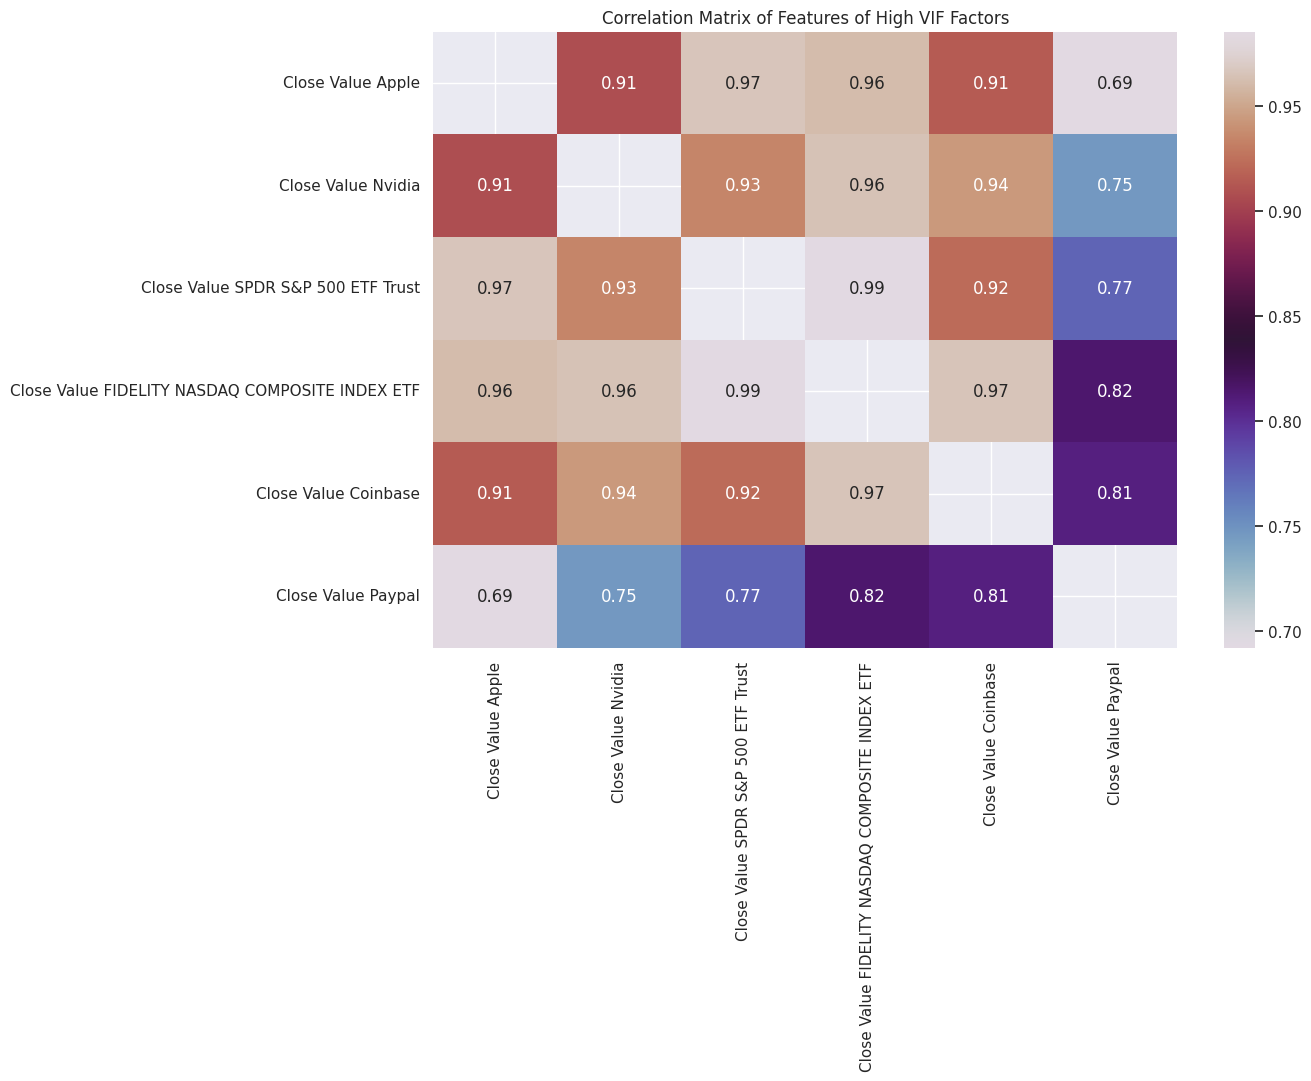

In [ ]:
#corr matrix for high VIF features
features_4 = dataset_2[['Close Value Apple', 'Close Value Nvidia', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF', 'Close Value Coinbase', 'Close Value Paypal']]
plt.figure(figsize=(12, 8))
corr_matrix = features_4.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',
fmt=".2f")
plt.title('Correlation Matrix of Features of High VIF Factors')
plt.show()

# Insights
We can see the following high correlations:
*  Close Value SPDR S&P 500 ETF Trust ~ Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF
*  Close Value SPDR S&P 500 ETF Trust and  Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF ~ Apple
* Apple ~ Nvidia
* Apple ~ Coinbase

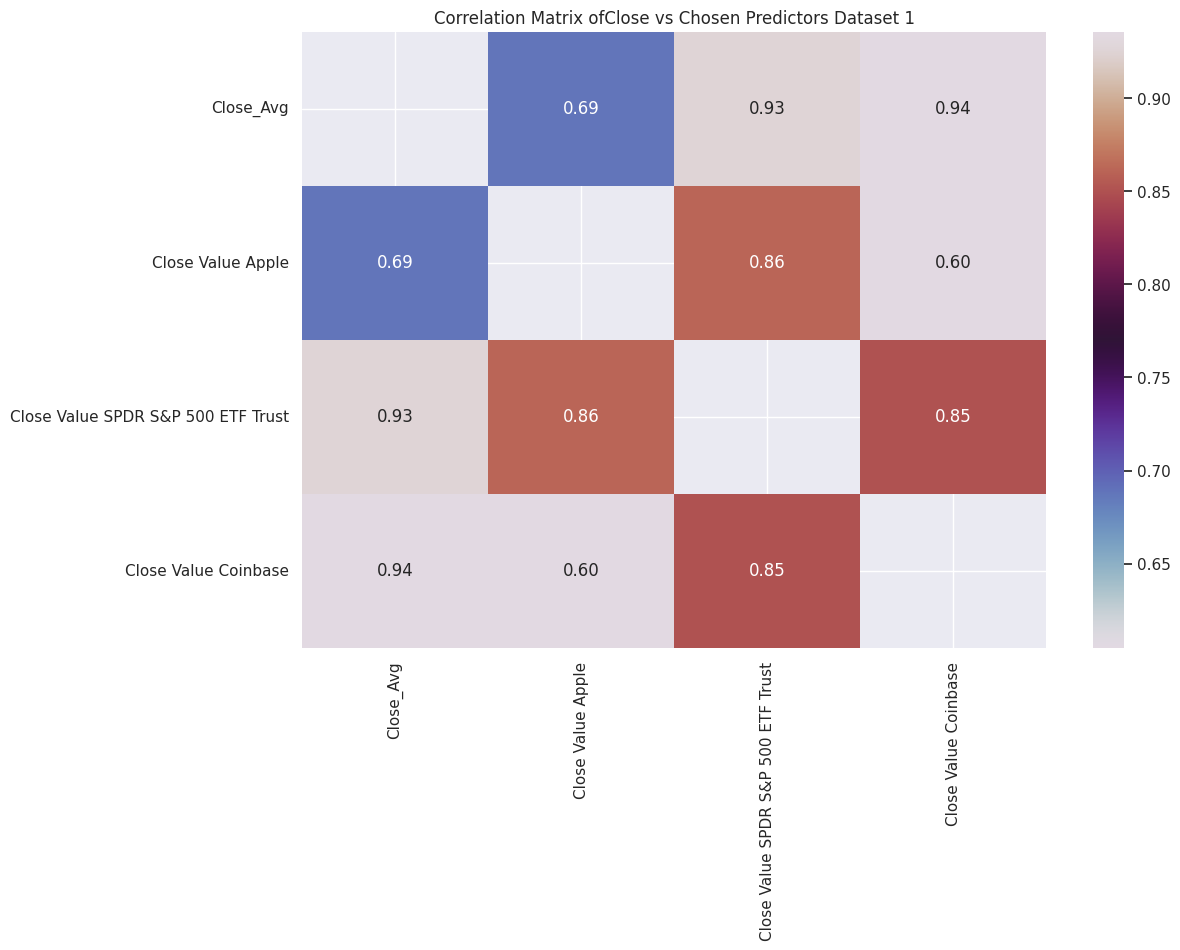

In [ ]:
#corr matrix for high VIF features
features_5_1 = dataset_1[['Close_Avg', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase']]
plt.figure(figsize=(12, 8))
corr_matrix = features_5_1.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',
fmt=".2f")
plt.title('Correlation Matrix ofClose vs Chosen Predictors Dataset 1')
plt.show()


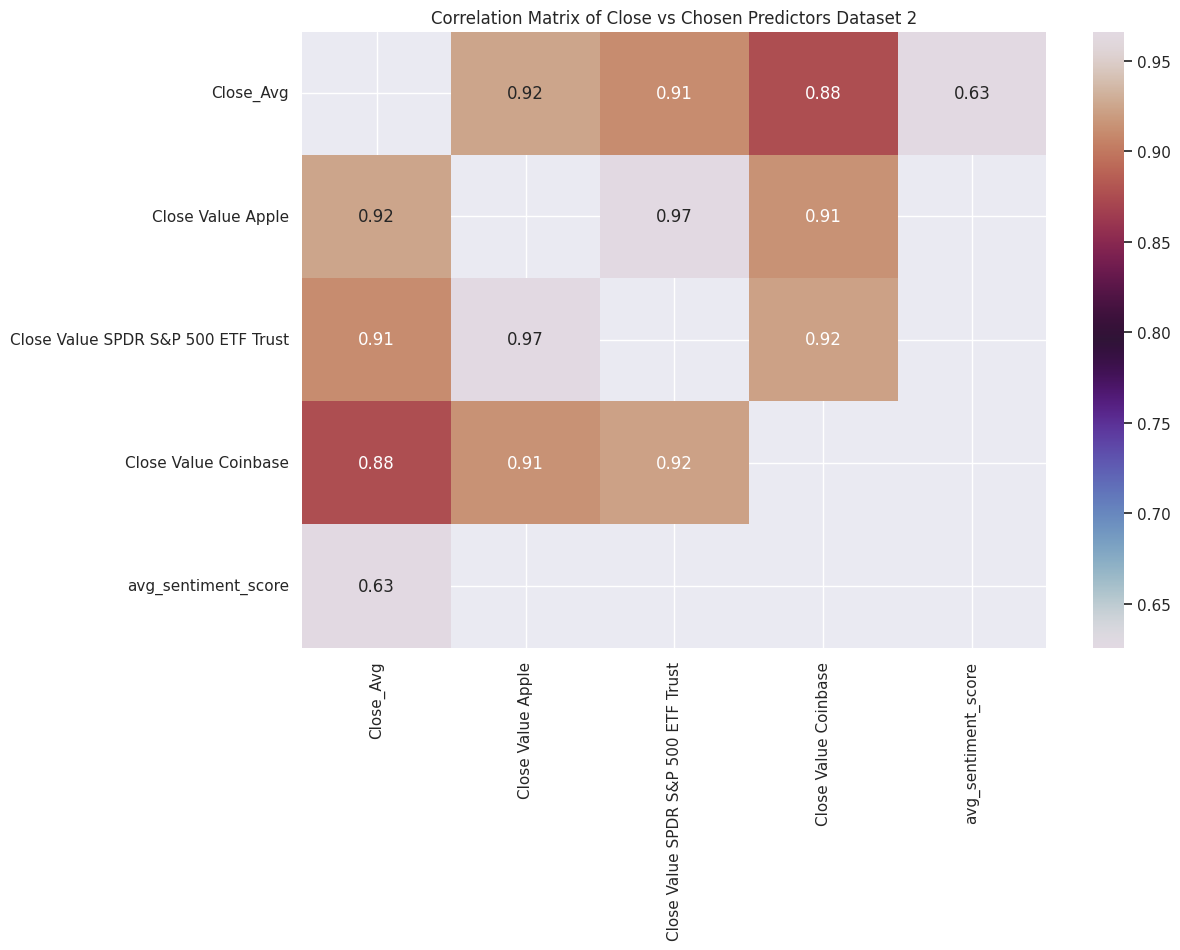

In [ ]:
#corr matrix for high VIF features
features_5 = dataset_2[['Close_Avg', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'avg_sentiment_score']]
plt.figure(figsize=(12, 8))
corr_matrix = features_5.corr()
sns.heatmap(corr_matrix[(np.abs(corr_matrix) >= 0.6) & (corr_matrix != 1)], annot=True, cmap='twilight',
fmt=".2f")
plt.title('Correlation Matrix of Close vs Chosen Predictors Dataset 2')
plt.show()


In [ ]:
features_6 = dataset_2[['Close Value Apple',  'Close Value Coinbase']]
X5 = add_constant(features_6)
vif_data_5 = pd.DataFrame()
vif_data_5["Feature"] = X5.columns
vif_data_5["VIF"] = [variance_inflation_factor(X5.values, i) for i in range(X5.shape[1])]
vif_data_5

,Feature,VIF
0,const,616.495259
1,Close Value Apple,6.114238
2,Close Value Coinbase,6.114238


In [ ]:
dataset_1_final = dataset_1.drop(columns=['Close Value Nvidia', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF',  'Close Value Tesla', 'Close Value Paypal', 'RSI'])
dataset_2_final = dataset_2.drop(columns=['Close Value Nvidia', 'Close Value FIDELITY NASDAQ COMPOSITE INDEX ETF',  'Close Value Tesla', 'Close Value Paypal', 'RSI'])


In [ ]:
dataset_2_final

,Time_UTC,Close_ET_4pm,Close_UTC_00,Close_Avg,Close Value Apple,Close Value SPDR S&P 500 ETF Trust,Close Value Coinbase,avg_sentiment_score
10,2022-01-11,41761.57,41562.14,41976.982285,175.08,469.75,237.23,0.210110
11,2022-01-12,43648.06,42764.23,42987.859528,175.53,471.02,234.70,0.260047
12,2022-01-13,43178.22,43630.60,43679.544292,172.19,464.53,228.23,0.222628
13,2022-01-14,43147.12,42765.83,42661.393736,173.07,464.72,230.03,0.253282
14,2022-01-15,43427.55,43084.89,43108.710208,173.07,464.72,230.03,0.253282
...,...,...,...,...,...,...,...,...
175,2022-06-25,20944.92,21240.67,21250.369646,141.66,390.08,62.71,0.179629
176,2022-06-26,21310.00,21208.04,21387.202549,141.66,390.08,62.71,0.195231
177,2022-06-27,20714.88,21279.31,21109.752069,141.66,388.59,55.96,0.195231
178,2022-06-28,20588.46,20857.57,20782.725354,137.44,380.65,51.18,0.151321


# Visualing Predictors for BTC

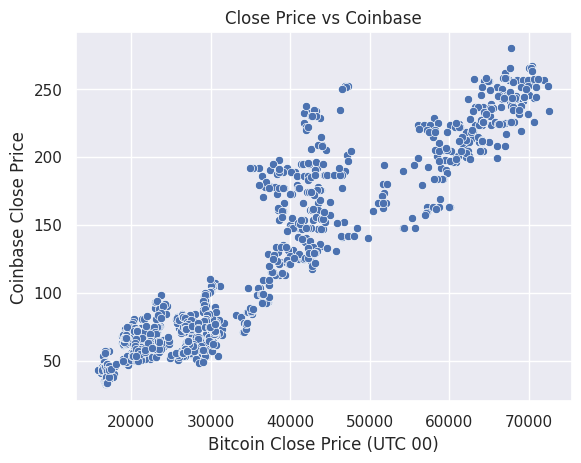

In [ ]:
#Prices vs Coinbase
sns.scatterplot(data=dataset_1_final, x="Close_Avg", y="Close Value Coinbase")
plt.title("Close Price vs Coinbase")
plt.xlabel("Bitcoin Close Price (Avg)")
plt.ylabel("Coinbase Close Price")
plt.show()


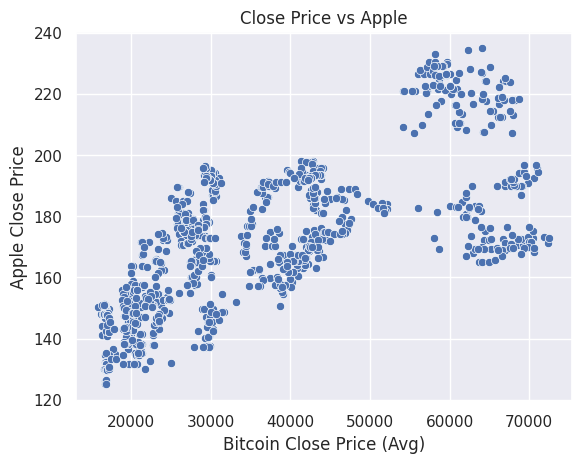

In [ ]:
#Prices vs Apple
sns.scatterplot(data=dataset_1_final, x="Close_Avg", y="Close Value Apple")
plt.title("Close Price vs Apple")
plt.xlabel("Bitcoin Close Price (Avg)")
plt.ylabel("Apple Close Price")
plt.show()


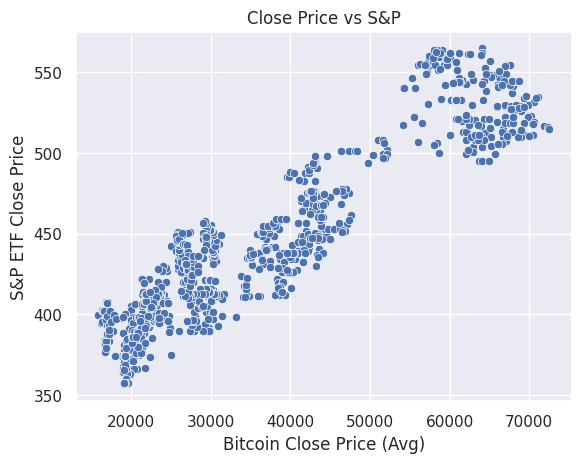

In [ ]:
#Prices vs ETF
sns.scatterplot(data=dataset_1_final, x="Close_Avg", y="Close Value SPDR S&P 500 ETF Trust")
plt.title("Close Price vs S&P")
plt.xlabel("Bitcoin Close Price (Avg)")
plt.ylabel("S&P ETF Close Price")
plt.show()


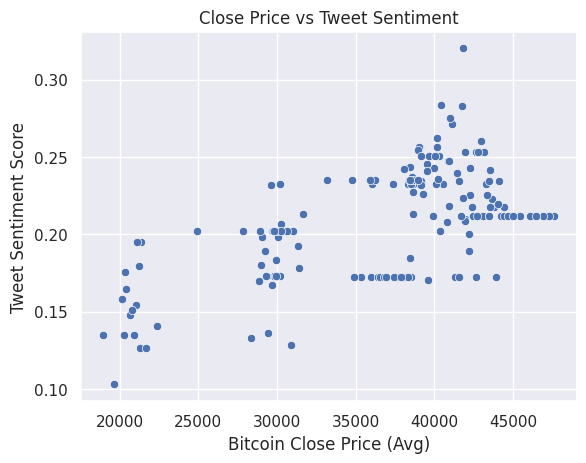

In [ ]:
#Prices vs tweets
sns.scatterplot(data=dataset_2_final, x="Close_Avg", y="avg_sentiment_score")
plt.title("Close Price vs Tweet Sentiment")
plt.xlabel("Bitcoin Close Price (Avg)")
plt.ylabel("Tweet Sentiment Score")
plt.show()


# Scaling Final Data

Due to the difference in scale of BTC vs the other stock amd the scale of tweet sentiment. All data except tweet sentiment will now be scaled using min/max scaler.

In [ ]:
# columns to scale (all except tweets)
columns = ['Close_Avg', 'Close_UTC_00', 'Close_ET_4pm', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase']

#using min max scaler
scaler = MinMaxScaler()
#fitting
scaled_data = scaler.fit_transform(dataset_1[columns])

# Scaling datasets 1 and 2
scaled_df = pd.DataFrame(scaled_data, columns=columns)
scaled_dataset_1 = pd.concat([dataset_1_final[['Time_UTC']], scaled_df], axis=1)
scaled_dataset_2 = pd.concat([dataset_2_final[['Time_UTC', 'avg_sentiment_score']], scaled_df], axis=1)



In [ ]:
scaled_dataset_1.head()

,Time_UTC,Close_Avg,Close_UTC_00,Close_ET_4pm,Close Value Apple,Close Value SPDR S&P 500 ETF Trust,Close Value Coinbase
0,2022-01-01,0.547344,0.533485,0.551347,0.478597,0.568411,0.889392
1,2022-01-02,0.555135,0.551399,0.551912,0.478597,0.568411,0.889392
2,2022-01-03,0.549743,0.541158,0.539575,0.519035,0.581613,0.884052
3,2022-01-04,0.539964,0.531334,0.542050,0.497996,0.580845,0.880411
4,2022-01-05,0.537233,0.517471,0.539240,0.454463,0.536822,0.816005


In [ ]:
scaled_dataset_2.head()

,Time_UTC,avg_sentiment_score,Close_Avg,Close_UTC_00,Close_ET_4pm,Close Value Apple,Close Value SPDR S&P 500 ETF Trust,Close Value Coinbase
10,2022-01-11,0.210110,0.460943,0.445929,0.453174,0.455920,0.543399,0.828141
11,2022-01-12,0.260047,0.478779,0.466867,0.486503,0.460018,0.549496,0.817906
12,2022-01-13,0.222628,0.490983,0.481957,0.478203,0.429599,0.518339,0.791731
13,2022-01-14,0.253282,0.473019,0.466895,0.477653,0.437614,0.519251,0.799013
14,2022-01-15,0.253282,0.480911,0.472452,0.482608,0.437614,0.519251,0.799013


# Visualizing Close Values over Time

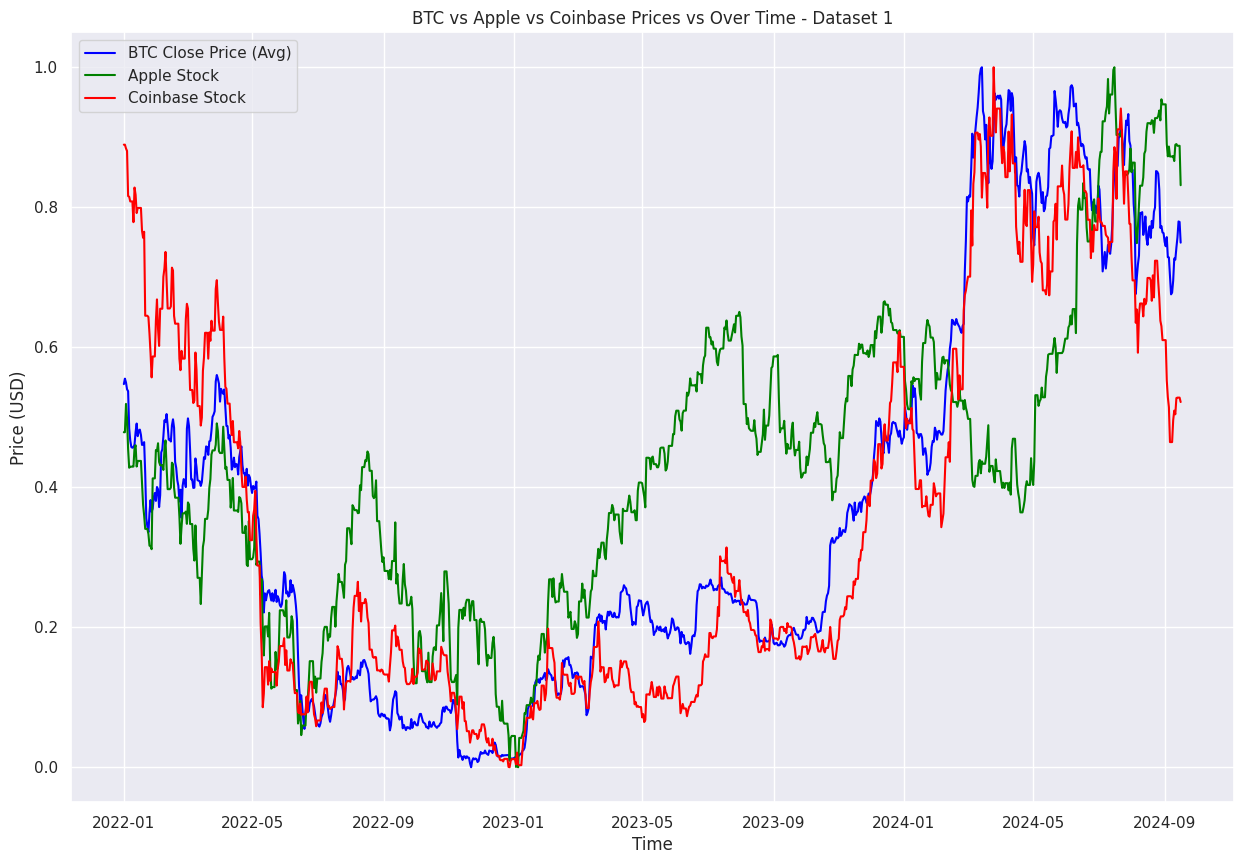

In [ ]:
#plotting dataset 1
plt.figure(figsize=(15, 10))
plt.plot(scaled_dataset_1["Time_UTC"], scaled_dataset_1["Close_Avg"], label="BTC Close Price (Avg)", color="blue")
plt.plot(scaled_dataset_1["Time_UTC"], scaled_dataset_1["Close Value Apple"], label="Apple Stock", color="green")
plt.plot(scaled_dataset_1["Time_UTC"], scaled_dataset_1["Close Value Coinbase"], label="Coinbase Stock", color="red")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.title("BTC vs Apple vs Coinbase Prices vs Over Time - Dataset 1")
plt.grid(True)
plt.show()

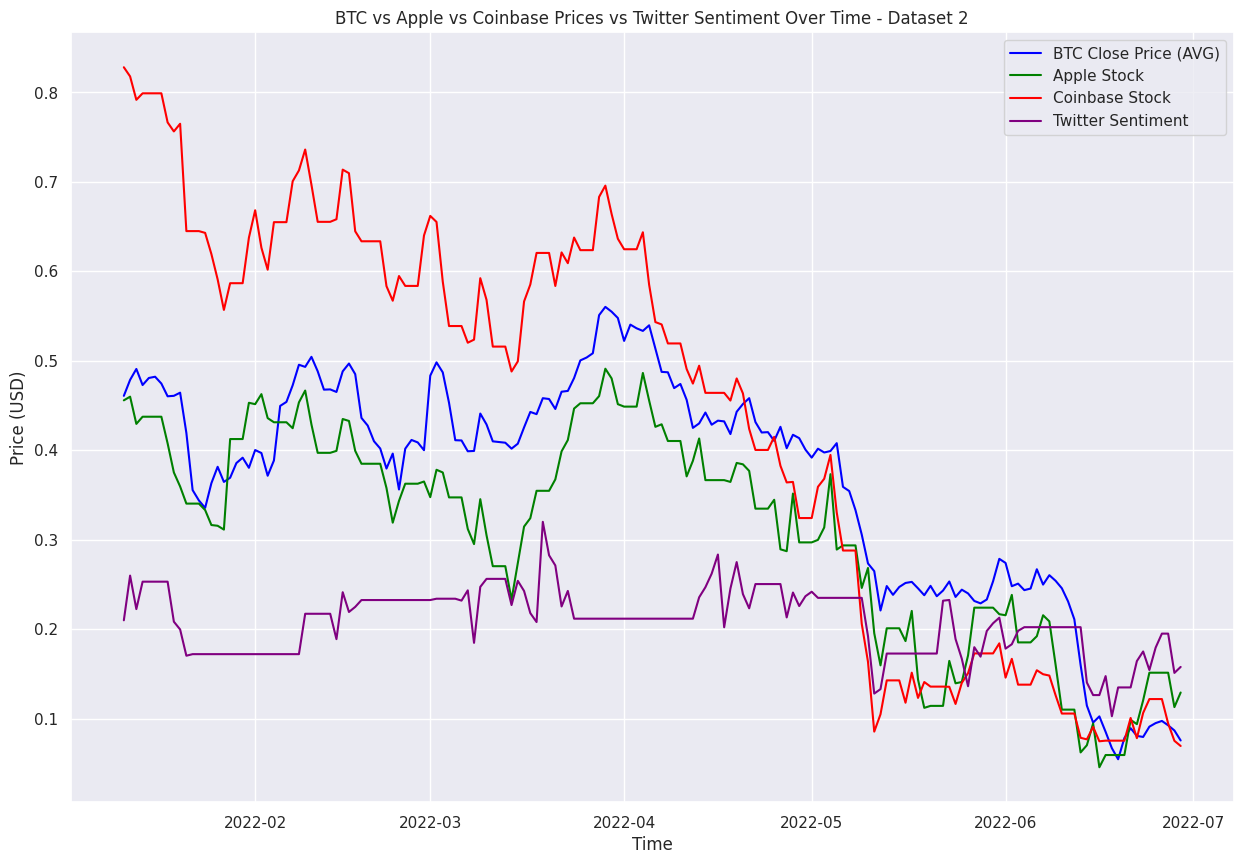

In [ ]:
#plotting dataset 2
plt.figure(figsize=(15, 10))
plt.plot(scaled_dataset_2["Time_UTC"], scaled_dataset_2["Close_Avg"], label="BTC Close Price (AVG)", color="blue")
plt.plot(scaled_dataset_2["Time_UTC"], scaled_dataset_2["Close Value Apple"], label="Apple Stock", color="green")
plt.plot(scaled_dataset_2["Time_UTC"], scaled_dataset_2["Close Value Coinbase"], label="Coinbase Stock", color="red")
plt.plot(scaled_dataset_2["Time_UTC"], scaled_dataset_2["avg_sentiment_score"], label= "Twitter Sentiment", color="purple")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.title("BTC vs Apple vs Coinbase Prices vs Twitter Sentiment Over Time - Dataset 2")
plt.grid(True)
plt.show()


In [ ]:
save_file_path = "/content/drive/My Drive/ML-project/"
scaled_dataset_1.to_csv(save_file_path + "scaled_data_1_final.csv", index=False)
scaled_dataset_2.to_csv(save_file_path + "scaled_data_2_final.csv", index=False)

### Future Notes
See Alpha Vantage Documentation [here](https://www.alphavantage.co/documentation/#).

#### Notes on using Alpha Vantage for Bitcoin Data
Excluded from this project as it only shows current and recent history but potentially useful for validation and comparing future price prediction. It returns the close price at 00:00 UTC.
```
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key

url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=demo&datatype=csv'

df = pd.read_csv(url)
```

#### Notes on Headline Data (Sentiment) from Alpha Vanatge
Possible future extension to include headlines and sentiments.
```
time_from = "20220701T0000"  # July 1, 2022
time_to = "20221231T2359"  # December 31, 2022
url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&time_from={time_from}&time_to={time_to}&limit=1000&apikey=GDL9DM00PWJL5YQ4"


r = requests.get(url)
data_2 = r.json()
```